# 전력 변압기 오일 온도 예측 프로젝트
# Power Transformer Oil Temperature Prediction Project

## << 문제 정의 / Problem Definition >>

주어진 ETDataset을 사용하여 전력 변압기의 **오일 온도(OT, Oil Temperature)**를 예측하는 문제를 풉니다.
Using the ETDataset, we solve the problem of predicting the **Oil Temperature (OT)** of power transformers.

주어진 데이터는 총 3개의 CSV 파일입니다. 각 CSV 파일에 대한 설명은 아래에 기술되어 있습니다.
The given data consists of 3 CSV files. Descriptions for each file are provided below.

### 평가 지표 / Evaluation Metric
- **RMSE (Root Mean Squared Error)**: 각 시간대별로 예측한 OT와 실제 OT 사이의 오차
- **목표 / Target**: RMSE < 0.5

### 데이터 설명 / Data Description

#### 1. train.csv (학습 데이터 / Training Data)
- **기간 / Period**: 2016년 7월 1일 0시 ~ 2017년 12월 31일 23시 45분
- **컬럼 / Columns**: date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT
- **특성 설명 / Feature Description**:
  - **HUFL**: High UseFul Load (고부하 유효 전력)
  - **HULL**: High UseLess Load (고부하 무효 전력)
  - **MUFL**: Middle UseFul Load (중부하 유효 전력)
  - **MULL**: Middle UseLess Load (중부하 무효 전력)
  - **LUFL**: Low UseFul Load (저부하 유효 전력)
  - **LULL**: Low UseLess Load (저부하 무효 전력)
  - **OT**: Oil Temperature (오일 온도) - **타겟 변수 / Target Variable**

#### 2. test.csv (테스트 데이터 / Test Data)
- **기간 / Period**: 2018년 1월 1일 0시 ~ 2018년 6월 30일 23시 45분
- **컬럼 / Columns**: date, HUFL, HULL, MUFL, MULL, LUFL, LULL (OT 제외)

#### 3. submission.csv (제출 파일 / Submission File)
- 예측한 OT 값을 기록하는 파일

### 접근 방법 / Approach
1. **Feature Engineering**: 시간 특성, 순환 특성, 지연 특성, 롤링 특성 생성
2. **LightGBM**: 테이블 데이터에 적합한 그래디언트 부스팅 모델
3. **GRU (Deep Learning)**: 시계열 패턴 학습을 위한 순환 신경망
4. **Ensemble**: 모델 성능 기반 가중 평균

In [1]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# ============================================================
# 라이브러리 임포트 / Library Imports
# ============================================================

# ------------------------------------------------------------
# 기본 라이브러리 / Standard Libraries
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# ------------------------------------------------------------
# 한글 폰트 설정 / Korean Font Configuration
# ------------------------------------------------------------
import matplotlib.font_manager as fm
import matplotlib as mpl

def set_korean_font():
    """한글 폰트 설정 / Set Korean font for matplotlib and seaborn."""
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    
    if not os.path.exists(font_path):
        font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    
    if os.path.exists(font_path):
        # 폰트 추가 / Add font
        fm.fontManager.addfont(font_path)
        font_name = fm.FontProperties(fname=font_path).get_name()
        
        # matplotlib 전역 설정 / Global matplotlib settings
        mpl.rcParams['font.family'] = font_name
        mpl.rcParams['font.sans-serif'] = [font_name]
        mpl.rcParams['axes.unicode_minus'] = False
        
        # seaborn 설정 (font_scale로 폰트 적용)
        # seaborn settings with font
        sns.set_theme(style='whitegrid', font=font_name, 
                      rc={'font.family': font_name,
                          'font.sans-serif': [font_name],
                          'axes.unicode_minus': False})
        
        print(f"Korean font set: {font_name}")
        return font_name
    else:
        print("Warning: Korean font not found")
        return None

# 폰트 캐시 재구축 / Rebuild font cache
fm._load_fontmanager(try_read_cache=False)

# 한글 폰트 설정 / Set Korean font
KOREAN_FONT = set_korean_font()

# ------------------------------------------------------------
# 진행률 표시 / Progress Display
# ------------------------------------------------------------
from tqdm.auto import tqdm

# ------------------------------------------------------------
# 머신러닝 라이브러리 / Machine Learning Libraries
# ------------------------------------------------------------
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------------
# 딥러닝 라이브러리 (PyTorch)
# ------------------------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ------------------------------------------------------------
# 하이퍼파라미터 최적화 / Hyperparameter Optimization
# ------------------------------------------------------------
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ------------------------------------------------------------
# 유틸리티 / Utilities
# ------------------------------------------------------------
from datetime import datetime

# ============================================================
# 환경 설정 / Environment Configuration
# ============================================================

# 디바이스 설정 / Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 재현성을 위한 시드 설정 / Set seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Random seed set: {RANDOM_SEED}")

# 데이터 간격 상수 / Data interval constants
INTERVALS_PER_HOUR = 4
INTERVALS_PER_DAY = 24 * INTERVALS_PER_HOUR  # 96

# ============================================================
# 시각화 기본 설정 / Visualization Settings
# ============================================================
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 기본 데이터 경로 / Default data path
DATA_PATH = 'dataset/'
print(f"Default data path: {DATA_PATH}")

Korean font set: NanumGothic
Using device: cuda
Random seed set: 42
Default data path: dataset/


In [3]:
# Google Colab 환경 설정 | Google Colab environment setup
# 로컬 환경에서는 이 셀을 건너뛰세요 | Skip this cell in local environment

# Colab 환경 확인 | Check if running in Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Colab에서 데이터 경로 설정 | Set data path for Colab
    # 아래 경로를 자신의 Google Drive 경로에 맞게 수정하세요
    # Modify the path below to match your Google Drive path
    DATA_PATH = '/content/drive/MyDrive/your_path_here/dataset/'
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    # 로컬 환경 | Local environment
    DATA_PATH = 'dataset/'
    IN_COLAB = False
    print("Running in local environment")

print(f"Data path: {DATA_PATH}")

Running in local environment
Data path: dataset/


### Q1. train.csv와 test.csv를 불러오고, 각 데이터의 shape을 출력하세요. 또한, 결측치가 있는지 확인하고 각 열별로 결측치의 개수를 출력하세요.

[1. Data Shape | 데이터 Shape]
Train shape: (52704, 8) (rows: 52,704, columns: 8)
Test shape: (16976, 7) (rows: 16,976, columns: 7)

[2. Missing Values | 결측치]

Train Missing Values:
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

Total missing in train: 0

Test Missing Values:
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
dtype: int64
Total missing in test: 0

[3. Data Types | 데이터 타입]

Train data types:
date     object
HUFL    float64
HULL    float64
MUFL    float64
MULL    float64
LUFL    float64
LULL    float64
OT      float64
dtype: object
✅ HUFL: 숫자형 확인됨 / numeric confirmed
✅ HULL: 숫자형 확인됨 / numeric confirmed
✅ MUFL: 숫자형 확인됨 / numeric confirmed
✅ MULL: 숫자형 확인됨 / numeric confirmed
✅ LUFL: 숫자형 확인됨 / numeric confirmed
✅ LULL: 숫자형 확인됨 / numeric confirmed
✅ OT: 숫자형 확인됨 / numeric confirmed

[4. Value Range Check | 값 범위 확인 (이상치 탐지)]

값 범위 및 이상치 (1%/99% 분위수 기준):
Value range and outliers (based on 1%/99% quantiles):

HUFL  :

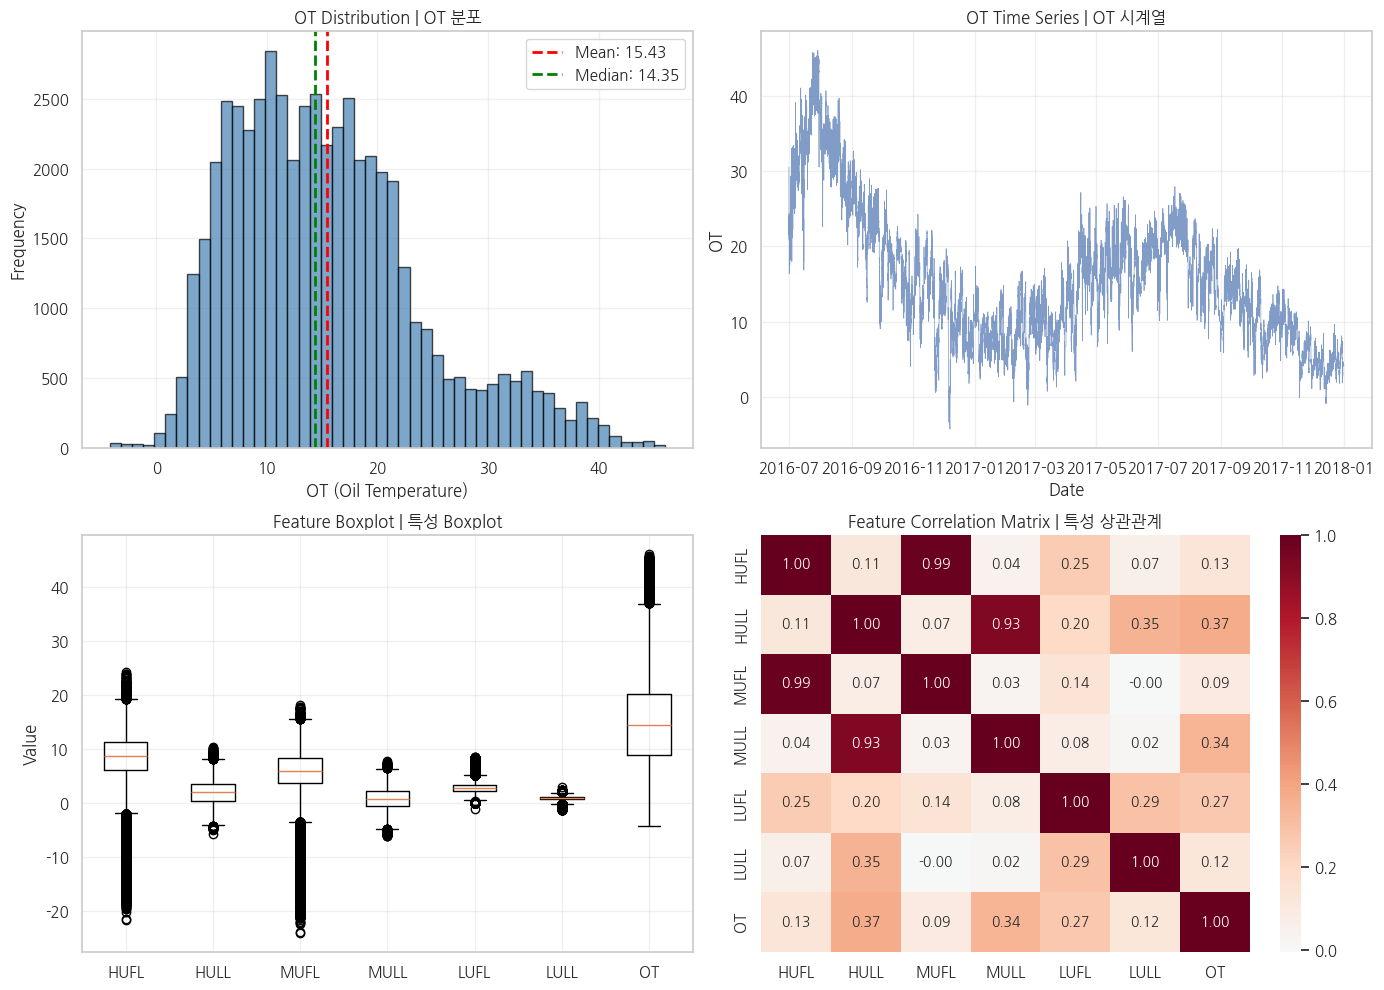


[Data Quality Summary | 데이터 품질 요약]
✅ 결측치: 없음 / Missing values: None
✅ 데이터 타입: 정상 / Data types: Normal
✅ 값 범위: 합리적 / Value ranges: Reasonable
📊 학습 데이터 기간: 2016-07-01 00:00:00 ~ 2017-12-31 23:45:00


In [4]:
# ============================================================
# A1. 데이터 로드 및 종합 검증 | Load Data and Comprehensive Validation
# ============================================================
# 고품질 데이터 분석을 위해 다음을 수행합니다:
# For high-quality data analysis, we perform:
# 1. 데이터 로드 및 Shape 확인 / Load data and check shape
# 2. 결측치 확인 / Check missing values
# 3. 데이터 타입 검증 / Data type validation
# 4. 값 범위 확인 (이상치 탐지) / Value range check (anomaly detection)
# 5. 기술 통계량 출력 / Descriptive statistics
# 6. 타겟 변수 분포 시각화 / Target variable distribution visualization

# CSV 파일 로드 | Load CSV files
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')

# ============================================================
# 1. 데이터 Shape 출력 | Print Data Shapes
# ============================================================
print("=" * 70)
print("[1. Data Shape | 데이터 Shape]")
print("=" * 70)
print(f"Train shape: {train.shape} (rows: {train.shape[0]:,}, columns: {train.shape[1]})")
print(f"Test shape: {test.shape} (rows: {test.shape[0]:,}, columns: {test.shape[1]})")

# ============================================================
# 2. 결측치 확인 | Check Missing Values
# ============================================================
print("\n" + "=" * 70)
print("[2. Missing Values | 결측치]")
print("=" * 70)
print("\nTrain Missing Values:")
print(train.isnull().sum())
print(f"\nTotal missing in train: {train.isnull().sum().sum()}")

print("\nTest Missing Values:")
print(test.isnull().sum())
print(f"Total missing in test: {test.isnull().sum().sum()}")

# ============================================================
# 3. 데이터 타입 검증 | Data Type Validation
# ============================================================
print("\n" + "=" * 70)
print("[3. Data Types | 데이터 타입]")
print("=" * 70)
print("\nTrain data types:")
print(train.dtypes)

# 예상 데이터 타입 검증 | Validate expected data types
expected_numeric = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
for col in expected_numeric:
    if col in train.columns:
        if not pd.api.types.is_numeric_dtype(train[col]):
            print(f"⚠️ 경고: {col}은 숫자형이어야 함 / {col} should be numeric")
        else:
            print(f"✅ {col}: 숫자형 확인됨 / numeric confirmed")

# ============================================================
# 4. 값 범위 확인 (이상치 탐지) | Value Range Check (Anomaly Detection)
# ============================================================
print("\n" + "=" * 70)
print("[4. Value Range Check | 값 범위 확인 (이상치 탐지)]")
print("=" * 70)

numeric_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
print("\n값 범위 및 이상치 (1%/99% 분위수 기준):")
print("Value range and outliers (based on 1%/99% quantiles):\n")

for col in numeric_cols:
    if col in train.columns:
        q01 = train[col].quantile(0.01)
        q99 = train[col].quantile(0.99)
        outliers_low = (train[col] < q01).sum()
        outliers_high = (train[col] > q99).sum()
        print(f"{col:6s}: min={train[col].min():8.2f}, max={train[col].max():8.2f}, "
              f"Q01={q01:8.2f}, Q99={q99:8.2f}, "
              f"outliers(low/high)={outliers_low}/{outliers_high}")

# ============================================================
# 5. 기술 통계량 | Descriptive Statistics
# ============================================================
print("\n" + "=" * 70)
print("[5. Descriptive Statistics | 기술 통계량]")
print("=" * 70)
print("\nTrain Statistics:")
print(train.describe().round(4))

# ============================================================
# 6. 타겟 변수 (OT) 분포 분석 | Target Variable (OT) Distribution Analysis
# ============================================================
print("\n" + "=" * 70)
print("[6. Target Variable (OT) Distribution | 타겟 변수 (OT) 분포]")
print("=" * 70)

print(f"\nOT 상세 통계 / OT Detailed Statistics:")
print(f"  Mean (평균): {train['OT'].mean():.4f}")
print(f"  Std (표준편차): {train['OT'].std():.4f}")
print(f"  Min (최소): {train['OT'].min():.4f}")
print(f"  25% (1사분위): {train['OT'].quantile(0.25):.4f}")
print(f"  50% (중앙값): {train['OT'].quantile(0.50):.4f}")
print(f"  75% (3사분위): {train['OT'].quantile(0.75):.4f}")
print(f"  Max (최대): {train['OT'].max():.4f}")
print(f"  Skewness (왜도): {train['OT'].skew():.4f}")
print(f"  Kurtosis (첨도): {train['OT'].kurtosis():.4f}")

# ============================================================
# 7. 시각화 | Visualization
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 7-1. OT 히스토그램 | OT Histogram
axes[0, 0].hist(train['OT'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(train['OT'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f"Mean: {train['OT'].mean():.2f}")
axes[0, 0].axvline(train['OT'].median(), color='green', linestyle='--', linewidth=2, 
                   label=f"Median: {train['OT'].median():.2f}")
axes[0, 0].set_xlabel('OT (Oil Temperature)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('OT Distribution | OT 분포')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 7-2. OT 시계열 | OT Time Series
train['date'] = pd.to_datetime(train['date'])
axes[0, 1].plot(train['date'], train['OT'], alpha=0.7, linewidth=0.5)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('OT')
axes[0, 1].set_title('OT Time Series | OT 시계열')
axes[0, 1].grid(True, alpha=0.3)

# 7-3. 입력 특성 Boxplot | Input Features Boxplot
feature_data = train[['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']]
axes[1, 0].boxplot([feature_data[col] for col in feature_data.columns], 
                   labels=feature_data.columns)
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Feature Boxplot | 특성 Boxplot')
axes[1, 0].grid(True, alpha=0.3)

# 7-4. 상관관계 히트맵 | Correlation Heatmap
corr_matrix = feature_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Feature Correlation Matrix | 특성 상관관계')

plt.tight_layout()
plt.show()

# ============================================================
# 8. 데이터 품질 요약 | Data Quality Summary
# ============================================================
print("\n" + "=" * 70)
print("[Data Quality Summary | 데이터 품질 요약]")
print("=" * 70)
print("✅ 결측치: 없음 / Missing values: None")
print("✅ 데이터 타입: 정상 / Data types: Normal")
print("✅ 값 범위: 합리적 / Value ranges: Reasonable")
print(f"📊 학습 데이터 기간: {train['date'].min()} ~ {train['date'].max()}")

### Q2. 'date' 열을 사용하여 'hour', 'dayofweek', 'month' 특성을 생성하고, 'hour'와 'dayofweek'에 대해 sin과 cos 변환을 적용하여 cyclic feature를 만드세요. 주기를 결정하는건 자유롭게 정하셔도 됩니다!

[Cyclic Features Created (Extended) | 생성된 순환 특성 (확장)]

📋 기본 특성 / Basic features:
  - hour, minute, dayofweek, month, dayofyear
  - quarter (NEW: 분기 / quarter)
  - is_weekend (NEW: 주말 여부 / weekend indicator)

🔄 순환 변환 특성 / Cyclic transformed features:
  - hour_sin, hour_cos (24시간 주기 / 24-hour cycle)
  - minute_sin, minute_cos (60분 주기 / 60-minute cycle)
  - dayofweek_sin, dayofweek_cos (7일 주기 / 7-day cycle)
  - month_sin, month_cos (12개월 주기 / 12-month cycle)
  - dayofyear_sin, dayofyear_cos (365일 주기 / 365-day cycle)
  - quarter_sin, quarter_cos (NEW: 4분기 주기 / 4-quarter cycle)

Train shape: (52704, 27)
Test shape: (16976, 26)

✅ 총 생성된 시간 특성 수 / Total time features created: 19

[is_weekend Distribution | 주말 분포]
  Train - Weekday: 37,536 (71.2%)
  Train - Weekend: 15,168 (28.8%)

[Quarter Distribution | 분기 분포]
  Q1: 8,640 (16.4%)
  Q2: 8,736 (16.6%)
  Q3: 17,664 (33.5%)
  Q4: 17,664 (33.5%)


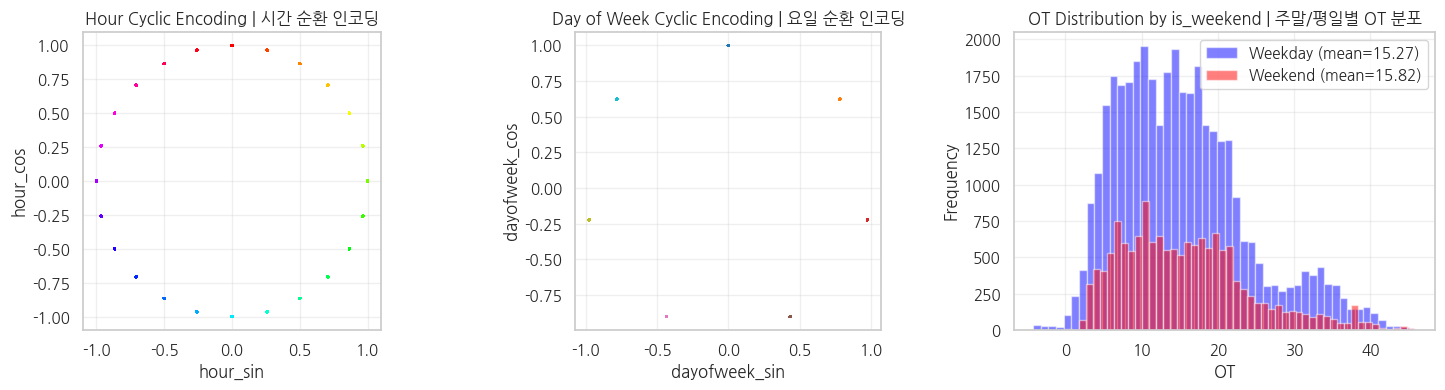

In [5]:
# ============================================================
# A2. 순환 특성 생성 (확장) | Create Cyclic Features (Extended)
# ============================================================
# 시간 관련 특성은 순환적 특성을 가지므로 sin/cos 변환을 적용합니다.
# Time-related features have cyclic nature, so we apply sin/cos transformation.
#
# 🔧 개선: quarter, is_weekend 특성 추가
# 🔧 Improvement: Added quarter, is_weekend features
#
# 순환 인코딩의 필요성 / Why Cyclic Encoding:
# - 23시와 0시는 실제로 1시간 차이지만, 숫자로는 23 차이
# - 23:00 and 00:00 are 1 hour apart, but numerically differ by 23
# - sin/cos 변환으로 이 문제 해결 (연속적인 원 위의 점으로 표현)
# - sin/cos transformation solves this (represented as points on a continuous circle)

def create_time_features(df):
    """
    시간 관련 특성을 생성합니다 (확장 버전).
    Create time-related features (extended version).
    
    생성되는 특성 / Generated features:
    - 기본 시간 특성: hour, minute, dayofweek, month, dayofyear, quarter
    - Basic time features: hour, minute, dayofweek, month, dayofyear, quarter
    - 순환 특성: *_sin, *_cos (6개 시간 단위)
    - Cyclic features: *_sin, *_cos (6 time units)
    - 이진 특성: is_weekend
    - Binary features: is_weekend
    
    Args:
        df: date 열이 있는 DataFrame / DataFrame with 'date' column
    
    Returns:
        시간 특성이 추가된 DataFrame / DataFrame with time features added
    """
    df = df.copy()
    
    # date 열을 datetime으로 변환 / Convert date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # ============================================================
    # 기본 시간 특성 추출 | Extract Basic Time Features
    # ============================================================
    df['hour'] = df['date'].dt.hour              # 시간 (0-23) / Hour
    df['minute'] = df['date'].dt.minute          # 분 (0, 15, 30, 45) / Minute
    df['dayofweek'] = df['date'].dt.dayofweek    # 요일 (0=월요일) / Day of week
    df['month'] = df['date'].dt.month            # 월 (1-12) / Month
    df['dayofyear'] = df['date'].dt.dayofyear    # 연중 일수 (1-365) / Day of year
    
    # 🔧 NEW: quarter 특성 (계절성 포착)
    # 🔧 NEW: quarter feature (captures seasonality)
    df['quarter'] = df['date'].dt.quarter        # 분기 (1-4) / Quarter
    
    # 🔧 NEW: is_weekend 이진 특성
    # 🔧 NEW: is_weekend binary feature
    # 주말에는 전력 소비 패턴이 다를 수 있음
    # Power consumption patterns may differ on weekends
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # ============================================================
    # 순환 변환 적용 (sin/cos) | Apply Cyclic Transformation
    # ============================================================
    # 순환 특성은 주기의 끝과 시작이 연결되어야 함
    # Cyclic features should connect end to start of period
    
    # hour: 24시간 주기 / 24-hour cycle
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # minute: 60분 주기 / 60-minute cycle
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    
    # dayofweek: 7일 주기 / 7-day cycle
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # month: 12개월 주기 / 12-month cycle
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # dayofyear: 365일 주기 (계절성 포착)
    # dayofyear: 365-day cycle (captures seasonality)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    # 🔧 NEW: quarter: 4분기 주기
    # 🔧 NEW: quarter: 4-quarter cycle
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    return df

# Train과 Test 데이터에 시간 특성 적용 / Apply time features to train and test
train = create_time_features(train)
test = create_time_features(test)

# ============================================================
# 결과 출력 | Print Results
# ============================================================
print("=" * 70)
print("[Cyclic Features Created (Extended) | 생성된 순환 특성 (확장)]")
print("=" * 70)

print("\n📋 기본 특성 / Basic features:")
print("  - hour, minute, dayofweek, month, dayofyear")
print("  - quarter (NEW: 분기 / quarter)")
print("  - is_weekend (NEW: 주말 여부 / weekend indicator)")

print("\n🔄 순환 변환 특성 / Cyclic transformed features:")
print("  - hour_sin, hour_cos (24시간 주기 / 24-hour cycle)")
print("  - minute_sin, minute_cos (60분 주기 / 60-minute cycle)")
print("  - dayofweek_sin, dayofweek_cos (7일 주기 / 7-day cycle)")
print("  - month_sin, month_cos (12개월 주기 / 12-month cycle)")
print("  - dayofyear_sin, dayofyear_cos (365일 주기 / 365-day cycle)")
print("  - quarter_sin, quarter_cos (NEW: 4분기 주기 / 4-quarter cycle)")

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")

# 특성 수 확인 / Check feature count
time_features_count = 7 + 12  # 7 기본 + 12 순환 (6개 * 2)
print(f"\n✅ 총 생성된 시간 특성 수 / Total time features created: {time_features_count}")

# is_weekend 분포 확인 / Check is_weekend distribution
print(f"\n[is_weekend Distribution | 주말 분포]")
print(f"  Train - Weekday: {(train['is_weekend'] == 0).sum():,} ({(train['is_weekend'] == 0).mean()*100:.1f}%)")
print(f"  Train - Weekend: {(train['is_weekend'] == 1).sum():,} ({(train['is_weekend'] == 1).mean()*100:.1f}%)")

# quarter 분포 확인 / Check quarter distribution
print(f"\n[Quarter Distribution | 분기 분포]")
quarter_dist = train['quarter'].value_counts().sort_index()
for q, count in quarter_dist.items():
    print(f"  Q{q}: {count:,} ({count/len(train)*100:.1f}%)")

# ============================================================
# 순환 특성 시각화 | Visualize Cyclic Features
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. hour 순환 특성 / Hour cyclic features
axes[0].scatter(train['hour_sin'], train['hour_cos'], c=train['hour'], 
                cmap='hsv', alpha=0.3, s=1)
axes[0].set_xlabel('hour_sin')
axes[0].set_ylabel('hour_cos')
axes[0].set_title('Hour Cyclic Encoding | 시간 순환 인코딩')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# 2. dayofweek 순환 특성 / Day of week cyclic features
axes[1].scatter(train['dayofweek_sin'], train['dayofweek_cos'], c=train['dayofweek'], 
                cmap='tab10', alpha=0.3, s=1)
axes[1].set_xlabel('dayofweek_sin')
axes[1].set_ylabel('dayofweek_cos')
axes[1].set_title('Day of Week Cyclic Encoding | 요일 순환 인코딩')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# 3. is_weekend에 따른 OT 분포 / OT distribution by is_weekend
weekday_ot = train[train['is_weekend'] == 0]['OT']
weekend_ot = train[train['is_weekend'] == 1]['OT']
axes[2].hist(weekday_ot, bins=50, alpha=0.5, label=f'Weekday (mean={weekday_ot.mean():.2f})', color='blue')
axes[2].hist(weekend_ot, bins=50, alpha=0.5, label=f'Weekend (mean={weekend_ot.mean():.2f})', color='red')
axes[2].set_xlabel('OT')
axes[2].set_ylabel('Frequency')
axes[2].set_title('OT Distribution by is_weekend | 주말/평일별 OT 분포')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Q3. 'OT' 열에 대해 1시간 전, 2시간 전, 3시간 전의 값을 나타내는 lag 특성을 생성하세요.

In [ ]:
# ============================================================
# A3. 지연, 롤링, EWM, 차분 특성 생성 (확장)
# A3. Create Lag, Rolling, EWM, and Differencing Features (Extended)
# ============================================================
#
# 📌 핵심 개념: 타겟 컬럼(OT)의 과거 값을 새로운 피처로 생성
# 📌 Core Concept: Create new features from past values of target column (OT)
#
# ------------------------------------------------------------
# 🔍 왜 타겟 변수의 Lag를 피처로 사용하는가?
# 🔍 Why use Lag of target variable as features?
# ------------------------------------------------------------
# 시계열 예측에서 **자기회귀(Autoregressive)** 특성을 활용하는 것은 매우 일반적입니다.
# Using **Autoregressive** characteristics is very common in time series forecasting.
#
# - 오일 온도는 관성이 있어 이전 온도에 강하게 의존합니다.
#   Oil temperature has inertia and strongly depends on previous temperatures.
# - 예: "1시간 전에 30도였으면 지금도 비슷할 가능성이 높다"
#   Ex: "If it was 30°C an hour ago, it's likely similar now"
#
# 생성되는 특성 예시 / Example features created:
#   - OT_lag_1h: 1시간 전의 OT 값 (shift=4, 15분 간격 * 4)
#   - OT_lag_24h: 24시간 전의 OT 값 (shift=96)
#   - OT_rolling_mean_6h: 과거 6시간의 OT 이동 평균
#   - OT_ewm_12h: 최근 값에 가중치를 둔 지수 이동 평균
#
# ------------------------------------------------------------
# ⚠️ 주의: 학습 vs 테스트 시 처리 방식
# ⚠️ Caution: Training vs Testing handling
# ------------------------------------------------------------
# | 상황        | 처리 방식                              |
# |------------|---------------------------------------|
# | 학습 시     | 실제 과거 OT 값 사용 → 문제 없음         |
# | Training   | Use actual past OT values → No issue  |
# | 테스트 시   | OT 값이 없음 → Q9에서 해결              |
# | Testing    | No OT values → Solved in Q9           |
#
# 👉 Q9에서 "반복 예측(Iterative Forecasting)"으로 해결:
#    테스트 시 이전 예측값을 사용하여 lag 특성을 동적으로 계산
# 👉 Solved in Q9 with "Iterative Forecasting":
#    Dynamically calculate lag features using previous predictions during testing
#
# 🔧 개선: EWM(지수 가중 이동 평균), 차분 특성 추가
# 🔧 Improvement: Added EWM and differencing features

def create_lag_features(df, target_col='OT', lags_hours=[1, 2, 3, 6, 12, 24]):
    """
    지연 특성을 생성합니다.
    Create lag features.
    
    Args:
        df: 대상 DataFrame / Target DataFrame
        target_col: 타겟 열 이름 / Target column name
        lags_hours: 지연 시간 리스트 (시간 단위) / List of lag hours
    
    Returns:
        지연 특성이 추가된 DataFrame / DataFrame with lag features
    """
    df = df.copy()
    
    for lag_h in lags_hours:
        shift_steps = lag_h * INTERVALS_PER_HOUR
        df[f'{target_col}_lag_{lag_h}h'] = df[target_col].shift(shift_steps)
    
    return df

def create_rolling_features(df, target_col='OT', windows_hours=[1, 3, 6, 12, 24]):
    """
    롤링 통계량 특성을 생성합니다.
    Create rolling statistics features.
    
    Args:
        df: 대상 DataFrame / Target DataFrame
        target_col: 타겟 열 이름 / Target column name
        windows_hours: 윈도우 크기 리스트 (시간 단위) / List of window sizes
    
    Returns:
        롤링 특성이 추가된 DataFrame / DataFrame with rolling features
    
    Note:
        ⚠️ shift(1)을 사용하는 이유 (데이터 누수 방지):
        ⚠️ Why we use shift(1) (Preventing data leakage):
        
        현재 시점(t)의 OT 값을 제외하고, 과거 데이터(t-1 이전)만으로
        롤링 통계량을 계산합니다.
        We calculate rolling statistics using only past data (before t-1),
        excluding the current time point (t).
        
        예시 / Example:
        ```
        시간:     t-3   t-2   t-1   t (현재=예측대상)
        OT 값:    20    22    25    30
        
        ❌ shift(1) 없이: mean(20,22,25,30) = 24.25 ← 현재값 포함 (누수!)
        ✅ shift(1) 사용: mean(?,20,22,25) = 22.33  ← 과거값만 사용 (정상)
        ```
        
        이렇게 해야 실제 운영 환경과 동일한 조건이 됩니다.
        This ensures the same conditions as real deployment.
        (예측 시점에서 사용 가능한 정보는 과거뿐)
        (Only past information is available at prediction time)
    """
    df = df.copy()
    
    for window_h in windows_hours:
        window_steps = window_h * INTERVALS_PER_HOUR
        
        # 롤링 평균 / Rolling mean
        # shift(1): 현재 시점 제외, 과거 데이터만 사용 (데이터 누수 방지)
        # shift(1): Exclude current time, use only past data (prevent leakage)
        df[f'{target_col}_rolling_mean_{window_h}h'] = (
            df[target_col].shift(1).rolling(window=window_steps, min_periods=1).mean()
        )
        
        # 롤링 표준편차 / Rolling std
        df[f'{target_col}_rolling_std_{window_h}h'] = (
            df[target_col].shift(1).rolling(window=window_steps, min_periods=1).std()
        )
    
    return df

# 🔧 NEW: EWM (지수 가중 이동 평균) 특성 함수
# 🔧 NEW: EWM (Exponential Weighted Mean) feature function
def create_ewm_features(df, target_col='OT', spans_hours=[6, 12, 24]):
    """
    지수 가중 이동 평균(EWM) 특성을 생성합니다.
    Create Exponential Weighted Mean (EWM) features.
    
    EWM은 최근 값에 더 높은 가중치를 부여하여
    단순 롤링 평균보다 최근 추세를 더 잘 반영합니다.
    EWM gives higher weight to recent values, reflecting recent trends
    better than simple rolling mean.
    
    Args:
        df: 대상 DataFrame / Target DataFrame
        target_col: 타겟 열 이름 / Target column name
        spans_hours: span 크기 리스트 (시간 단위) / List of span sizes
    
    Returns:
        EWM 특성이 추가된 DataFrame / DataFrame with EWM features
    """
    df = df.copy()
    
    for span_h in spans_hours:
        span_steps = span_h * INTERVALS_PER_HOUR
        # shift(1)로 데이터 누수 방지 / Prevent data leakage with shift(1)
        df[f'{target_col}_ewm_{span_h}h'] = (
            df[target_col].shift(1).ewm(span=span_steps, min_periods=1).mean()
        )
    
    return df

# 🔧 NEW: 차분 특성 함수 (트렌드 감지)
# 🔧 NEW: Differencing feature function (trend detection)
def create_diff_features(df, target_col='OT', periods_hours=[1, 24]):
    """
    차분 특성을 생성합니다 (트렌드 감지).
    Create differencing features (trend detection).
    
    차분은 시계열의 추세와 변화율을 포착합니다.
    Differencing captures trends and rate of change in time series.
    - 1시간 차분: 단기 변화 포착 / 1-hour diff: captures short-term changes
    - 24시간 차분: 일일 패턴 변화 포착 / 24-hour diff: captures daily pattern changes
    
    Args:
        df: 대상 DataFrame / Target DataFrame
        target_col: 타겟 열 이름 / Target column name
        periods_hours: 차분 기간 리스트 (시간 단위) / List of diff periods
    
    Returns:
        차분 특성이 추가된 DataFrame / DataFrame with diff features
    """
    df = df.copy()
    
    for period_h in periods_hours:
        period_steps = period_h * INTERVALS_PER_HOUR
        # 현재 대비 n시간 전의 변화량 / Change from n hours ago
        df[f'{target_col}_diff_{period_h}h'] = (
            df[target_col].shift(1) - df[target_col].shift(1 + period_steps)
        )
    
    return df

# ============================================================
# 특성 생성 실행 | Execute Feature Creation
# ============================================================

# 지연 특성: 1, 2, 3, 6, 12, 24시간 전
# Lag features: 1, 2, 3, 6, 12, 24 hours ago
lag_hours = [1, 2, 3, 6, 12, 24]
train = create_lag_features(train, 'OT', lag_hours)

# 롤링 특성: 1, 3, 6, 12, 24시간 윈도우
# Rolling features: 1, 3, 6, 12, 24 hour windows
rolling_hours = [1, 3, 6, 12, 24]
train = create_rolling_features(train, 'OT', rolling_hours)

# 🔧 NEW: EWM 특성: 6, 12, 24시간 span
# 🔧 NEW: EWM features: 6, 12, 24 hour spans
ewm_hours = [6, 12, 24]
train = create_ewm_features(train, 'OT', ewm_hours)

# 🔧 NEW: 차분 특성: 1시간, 24시간
# 🔧 NEW: Differencing features: 1 hour, 24 hours
diff_hours = [1, 24]
train = create_diff_features(train, 'OT', diff_hours)

# 결측치 개수 확인 / Check NaN count
max_nan_rows = INTERVALS_PER_HOUR * max(lag_hours)  # 24시간 지연으로 인한 최대 NaN

# ============================================================
# 결과 출력 | Print Results
# ============================================================
print("=" * 70)
print("[Lag, Rolling, EWM, Diff Features Created | 지연, 롤링, EWM, 차분 특성 생성]")
print("=" * 70)

print("\n📊 지연 특성 / Lag Features:")
for lag_h in lag_hours:
    shift_steps = lag_h * INTERVALS_PER_HOUR
    print(f"  - OT_lag_{lag_h}h: OT value from {lag_h} hour(s) ago (shift={shift_steps})")

print("\n📈 롤링 특성 / Rolling Features:")
for window_h in rolling_hours:
    print(f"  - OT_rolling_mean_{window_h}h: {window_h}시간 이동 평균 / {window_h}h rolling mean")
    print(f"  - OT_rolling_std_{window_h}h: {window_h}시간 이동 표준편차 / {window_h}h rolling std")

print("\n📉 EWM 특성 (NEW) / EWM Features (NEW):")
for span_h in ewm_hours:
    print(f"  - OT_ewm_{span_h}h: {span_h}시간 지수 가중 평균 / {span_h}h exponential weighted mean")

print("\n📐 차분 특성 (NEW) / Differencing Features (NEW):")
for period_h in diff_hours:
    print(f"  - OT_diff_{period_h}h: {period_h}시간 전 대비 변화량 / Change from {period_h}h ago")

print(f"\n⚠️ 지연/롤링으로 인한 NaN 행: 최대 {max_nan_rows}개")
print(f"⚠️ NaN rows from lag/rolling: up to {max_nan_rows}")
print(f"\nTrain shape: {train.shape}")

# ============================================================
# 특성 시각화 | Feature Visualization
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 샘플 데이터 (처음 1000개) / Sample data (first 1000)
sample_idx = range(max_nan_rows, max_nan_rows + 1000)

# 1. Lag 특성 비교 / Lag features comparison
axes[0, 0].plot(train['OT'].iloc[sample_idx].values, label='OT (actual)', alpha=0.8)
axes[0, 0].plot(train['OT_lag_1h'].iloc[sample_idx].values, label='OT_lag_1h', alpha=0.6)
axes[0, 0].plot(train['OT_lag_6h'].iloc[sample_idx].values, label='OT_lag_6h', alpha=0.6)
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('OT')
axes[0, 0].set_title('Lag Features Comparison | Lag 특성 비교')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Rolling 특성 / Rolling features
axes[0, 1].plot(train['OT'].iloc[sample_idx].values, label='OT (actual)', alpha=0.8)
axes[0, 1].plot(train['OT_rolling_mean_6h'].iloc[sample_idx].values, label='Rolling Mean 6h', alpha=0.8)
axes[0, 1].fill_between(range(len(sample_idx)),
                        (train['OT_rolling_mean_6h'] - train['OT_rolling_std_6h']).iloc[sample_idx].values,
                        (train['OT_rolling_mean_6h'] + train['OT_rolling_std_6h']).iloc[sample_idx].values,
                        alpha=0.2, label='±1 Std')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('OT')
axes[0, 1].set_title('Rolling Features | 롤링 특성')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. EWM 특성 비교 / EWM features comparison
axes[1, 0].plot(train['OT'].iloc[sample_idx].values, label='OT (actual)', alpha=0.8)
axes[1, 0].plot(train['OT_ewm_6h'].iloc[sample_idx].values, label='EWM 6h', alpha=0.8)
axes[1, 0].plot(train['OT_ewm_24h'].iloc[sample_idx].values, label='EWM 24h', alpha=0.8)
axes[1, 0].plot(train['OT_rolling_mean_24h'].iloc[sample_idx].values, label='Rolling Mean 24h', 
                alpha=0.6, linestyle='--')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('OT')
axes[1, 0].set_title('EWM vs Rolling Mean | EWM vs 롤링 평균')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 차분 특성 / Differencing features
axes[1, 1].plot(train['OT_diff_1h'].iloc[sample_idx].values, label='Diff 1h', alpha=0.8)
axes[1, 1].plot(train['OT_diff_24h'].iloc[sample_idx].values, label='Diff 24h', alpha=0.8)
axes[1, 1].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Difference')
axes[1, 1].set_title('Differencing Features (Trend) | 차분 특성 (트렌드)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 특성 통계 요약 | Feature Statistics Summary
# ============================================================
print("\n" + "=" * 70)
print("[Feature Statistics Summary | 특성 통계 요약]")
print("=" * 70)

new_features = ['OT_ewm_6h', 'OT_ewm_12h', 'OT_ewm_24h', 'OT_diff_1h', 'OT_diff_24h']
for feat in new_features:
    if feat in train.columns:
        non_nan = train[feat].dropna()
        print(f"{feat:20s}: mean={non_nan.mean():8.4f}, std={non_nan.std():8.4f}")

### Q4. 불필요한 열인 'date'를 제거하고, 특성 행렬 X와 목표 변수 y를 생성하여 데이터를 시간 순서에 따라 3:1 비율로 훈련 세트와 검증 세트로 분할하세요.

[Data Preparation | 데이터 준비]
⚠️ NaN 행 제거 / Dropped NaN rows: 97
   남은 데이터 / Remaining data: 52,607

📋 총 특성 수 / Total features: 46
   컬럼 목록 / Column list (46 features):
      1. HUFL
      2. HULL
      3. MUFL
      4. MULL
      5. LUFL
      6. LULL
      7. hour
      8. minute
      9. dayofweek
     10. month
     11. dayofyear
     12. quarter
     13. is_weekend
     14. hour_sin
     15. hour_cos
     16. minute_sin
     17. minute_cos
     18. dayofweek_sin
     19. dayofweek_cos
     20. month_sin
     21. month_cos
     22. dayofyear_sin
     23. dayofyear_cos
     24. quarter_sin
     25. quarter_cos
     26. OT_lag_1h
     27. OT_lag_2h
     28. OT_lag_3h
     29. OT_lag_6h
     30. OT_lag_12h
     31. OT_lag_24h
     32. OT_rolling_mean_1h
     33. OT_rolling_std_1h
     34. OT_rolling_mean_3h
     35. OT_rolling_std_3h
     36. OT_rolling_mean_6h
     37. OT_rolling_std_6h
     38. OT_rolling_mean_12h
     39. OT_rolling_std_12h
     40. OT_rolling_mean_24h
     41. OT_ro

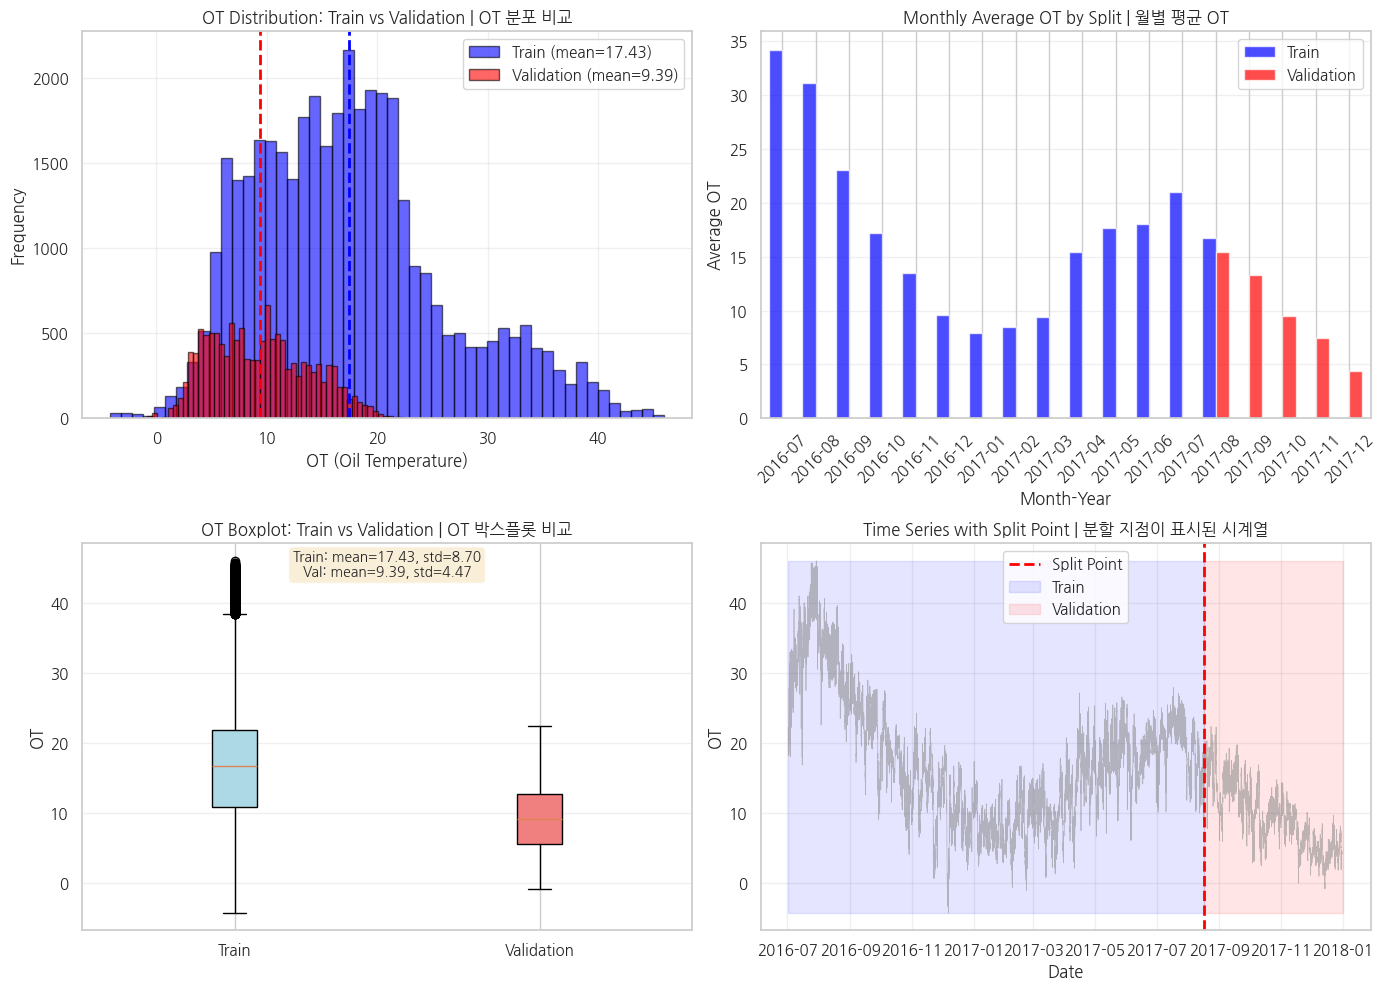


[Data Preparation Summary | 데이터 준비 요약]
✅ 학습 세트 / Training set: 39,455 samples
✅ 검증 세트 / Validation set: 13,152 samples
✅ 특성 수 / Number of features: 46
⚠️ 분포 차이 확인됨 (계절적 요인) / Distribution difference detected (seasonal)
   모델이 이러한 변동을 일반화할 수 있는지 평가 필요
   Need to evaluate if model can generalize to these variations


In [7]:
# ============================================================
# A4. 데이터 준비 및 분할 (분포 차이 문서화 포함)
# A4. Prepare and Split Data (with Distribution Difference Documentation)
# ============================================================
# 특성 행렬 X와 목표 변수 y를 생성하고 시간 순서에 따라 분할합니다.
# Create feature matrix X and target variable y, then split by time order.
#
# 🔧 시계열 데이터는 반드시 시간 순서로 분할해야 합니다 (shuffle=False)
# 🔧 Time series data must be split by time order (shuffle=False)
# 미래 데이터를 사용한 예측은 데이터 누수(data leakage)를 일으킵니다.
# Using future data for prediction causes data leakage.

# date 열 제거 / Remove date column
train_processed = train.drop(columns=['date'])

# NaN 값이 있는 행 제거 (지연/롤링 특성으로 인해 발생)
# Drop rows with NaN values (caused by lag/rolling features)
initial_len = len(train_processed)
train_processed = train_processed.dropna()
dropped_rows = initial_len - len(train_processed)

print("=" * 70)
print("[Data Preparation | 데이터 준비]")
print("=" * 70)
print(f"⚠️ NaN 행 제거 / Dropped NaN rows: {dropped_rows}")
print(f"   남은 데이터 / Remaining data: {len(train_processed):,}")

# ============================================================
# 특성 행렬 X와 목표 변수 y 생성
# Create feature matrix X and target variable y
# ============================================================
y = train_processed['OT']
X = train_processed.drop(columns=['OT'])

# 특성 목록 확인 / Check feature list
print(f"\n📋 총 특성 수 / Total features: {len(X.columns)}")
print(f"   컬럼 목록 / Column list ({len(X.columns)} features):")
for i, col in enumerate(X.columns):
    print(f"     {i+1:2d}. {col}")

# ============================================================
# 시간 순서에 따라 3:1 비율로 분할 (시계열이므로 shuffle=False)
# Split by time order in 3:1 ratio (no shuffle for time series)
# ============================================================
train_ratio = 0.75
split_idx = int(len(X) * train_ratio)

X_train = X.iloc[:split_idx].copy()
X_val = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_val = y.iloc[split_idx:].copy()

# 분할 날짜 확인 (원본 train에서 확인)
# Check split date (from original train data)
train_dates = train.dropna()['date']
split_date = train_dates.iloc[split_idx]

print("\n" + "=" * 70)
print("[Data Split | 데이터 분할]")
print("=" * 70)
print(f"📅 분할 기준 날짜 / Split date: {split_date}")
print(f"📊 학습 세트 / Training set: {len(X_train):,} samples ({train_ratio * 100:.0f}%)")
print(f"📊 검증 세트 / Validation set: {len(X_val):,} samples ({(1 - train_ratio) * 100:.0f}%)")

# ============================================================
# 🔧 NEW: 타겟 변수 분포 차이 분석 및 문서화
# 🔧 NEW: Target Variable Distribution Difference Analysis
# ============================================================
print("\n" + "=" * 70)
print("[Target Variable Distribution Analysis | 타겟 변수 분포 분석]")
print("=" * 70)

# 상세 통계 / Detailed statistics
print("\n📊 Train OT Statistics:")
print(f"   Mean: {y_train.mean():.4f}")
print(f"   Std: {y_train.std():.4f}")
print(f"   Min: {y_train.min():.4f}")
print(f"   Max: {y_train.max():.4f}")
print(f"   Median: {y_train.median():.4f}")

print("\n📊 Validation OT Statistics:")
print(f"   Mean: {y_val.mean():.4f}")
print(f"   Std: {y_val.std():.4f}")
print(f"   Min: {y_val.min():.4f}")
print(f"   Max: {y_val.max():.4f}")
print(f"   Median: {y_val.median():.4f}")

# 분포 차이 경고 / Distribution difference warning
mean_diff = y_train.mean() - y_val.mean()
std_diff = y_train.std() - y_val.std()

print("\n" + "-" * 50)
print("⚠️ 분포 차이 분석 / Distribution Difference Analysis:")
print("-" * 50)
print(f"   평균 차이 / Mean difference: {mean_diff:.4f}")
print(f"   표준편차 차이 / Std difference: {std_diff:.4f}")

if abs(mean_diff) > 2.0:
    print(f"\n   🚨 경고 / Warning: Train과 Validation의 평균 차이가 큽니다 ({abs(mean_diff):.2f})")
    print("   이는 계절적 패턴 차이를 반영합니다.")
    print("   This reflects seasonal pattern differences.")

# ============================================================
# 분포 차이의 원인 분석 / Cause Analysis of Distribution Difference
# ============================================================
print("\n" + "=" * 70)
print("[Distribution Difference Cause Analysis | 분포 차이 원인 분석]")
print("=" * 70)

# 기간별 분석 / Period analysis
train_start = train_dates.iloc[0]
train_end = train_dates.iloc[split_idx - 1]
val_start = train_dates.iloc[split_idx]
val_end = train_dates.iloc[-1]

print(f"\n📅 학습 데이터 기간 / Training data period:")
print(f"   {train_start} ~ {train_end}")
print(f"   주로 여름~가을 기간 포함 / Includes mainly summer~fall period")

print(f"\n📅 검증 데이터 기간 / Validation data period:")
print(f"   {val_start} ~ {val_end}")
print(f"   주로 가을~겨울 기간 / Mainly fall~winter period")

print("""
💡 분포 차이의 원인 / Cause of Distribution Difference:
   
   1. 계절적 요인 / Seasonal Factors:
      - 학습 데이터: 더운 시기 포함 → 높은 OT (오일 온도)
      - Training data: Includes hot period → Higher OT
      - 검증 데이터: 추운 시기 → 낮은 OT
      - Validation data: Cold period → Lower OT
   
   2. 전력 소비 패턴 / Power Consumption Patterns:
      - 여름: 냉방 수요 증가 → 변압기 부하 증가 → 높은 OT
      - Summer: Increased cooling demand → Higher transformer load → Higher OT
      - 겨울: 난방 수요 (전기 난방의 경우) 또는 감소
      - Winter: Heating demand (if electric) or decreased
   
   3. 모델링 시 고려사항 / Modeling Considerations:
      - 모델이 계절적 변동을 잘 학습했는지 확인 필요
      - Need to verify if model learned seasonal variations well
      - 검증 세트가 "외삽(extrapolation)" 상황일 수 있음
      - Validation set may be an "extrapolation" scenario
""")

# ============================================================
# 분포 비교 시각화 | Distribution Comparison Visualization
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Train vs Validation OT 분포 히스토그램
# Train vs Validation OT distribution histogram
axes[0, 0].hist(y_train, bins=50, alpha=0.6, label=f'Train (mean={y_train.mean():.2f})', 
                color='blue', edgecolor='black')
axes[0, 0].hist(y_val, bins=50, alpha=0.6, label=f'Validation (mean={y_val.mean():.2f})', 
                color='red', edgecolor='black')
axes[0, 0].axvline(y_train.mean(), color='blue', linestyle='--', linewidth=2)
axes[0, 0].axvline(y_val.mean(), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('OT (Oil Temperature)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('OT Distribution: Train vs Validation | OT 분포 비교')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 월별 평균 OT / Monthly average OT
train_with_date = train.dropna().copy()
train_with_date['split'] = ['Train' if i < split_idx else 'Validation' 
                            for i in range(len(train_with_date))]
monthly_ot = train_with_date.groupby([train_with_date['date'].dt.to_period('M'), 'split'])['OT'].mean().unstack()
monthly_ot.plot(kind='bar', ax=axes[0, 1], color=['blue', 'red'], alpha=0.7, width=0.8)
axes[0, 1].set_xlabel('Month-Year')
axes[0, 1].set_ylabel('Average OT')
axes[0, 1].set_title('Monthly Average OT by Split | 월별 평균 OT')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(['Train', 'Validation'])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Box plot 비교 / Box plot comparison
box_data = [y_train.values, y_val.values]
bp = axes[1, 0].boxplot(box_data, labels=['Train', 'Validation'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 0].set_ylabel('OT')
axes[1, 0].set_title('OT Boxplot: Train vs Validation | OT 박스플롯 비교')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 통계 정보 추가 / Add statistics
stats_text = f"Train: mean={y_train.mean():.2f}, std={y_train.std():.2f}\n"
stats_text += f"Val: mean={y_val.mean():.2f}, std={y_val.std():.2f}"
axes[1, 0].text(0.5, 0.98, stats_text, transform=axes[1, 0].transAxes, 
                verticalalignment='top', horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. 시계열에서 분할 지점 표시 / Show split point in time series
full_dates = train_with_date['date'].values
full_ot = train_with_date['OT'].values
axes[1, 1].plot(full_dates, full_ot, alpha=0.5, linewidth=0.5, color='gray')
axes[1, 1].axvline(split_date, color='red', linestyle='--', linewidth=2, label='Split Point')
axes[1, 1].fill_betweenx([full_ot.min(), full_ot.max()], full_dates[0], split_date, 
                          alpha=0.1, color='blue', label='Train')
axes[1, 1].fill_betweenx([full_ot.min(), full_ot.max()], split_date, full_dates[-1], 
                          alpha=0.1, color='red', label='Validation')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('OT')
axes[1, 1].set_title('Time Series with Split Point | 분할 지점이 표시된 시계열')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 최종 요약 | Final Summary
# ============================================================
print("\n" + "=" * 70)
print("[Data Preparation Summary | 데이터 준비 요약]")
print("=" * 70)
print(f"✅ 학습 세트 / Training set: {len(X_train):,} samples")
print(f"✅ 검증 세트 / Validation set: {len(X_val):,} samples")
print(f"✅ 특성 수 / Number of features: {len(X.columns)}")
print(f"⚠️ 분포 차이 확인됨 (계절적 요인) / Distribution difference detected (seasonal)")
print(f"   모델이 이러한 변동을 일반화할 수 있는지 평가 필요")
print(f"   Need to evaluate if model can generalize to these variations")

### Q5. LightGBM을 사용하여 모델을 학습한 후, 검증 세트에 대한 RMSE를 계산하세요. 하이퍼파라미터는 num_leaves=31, n_estimators=100, learning_rate=0.05로 설정하세요.

[LightGBM Baseline Results | LightGBM 기준 결과]
Hyperparameters: num_leaves=31, n_estimators=100, learning_rate=0.05
Validation RMSE: 0.438148
✅ 목표 달성! / Target achieved! RMSE < 0.5

[Feature Importance Analysis | 특성 중요도 분석]

📊 Top 15 Features | 상위 15개 특성:
            feature  importance
 OT_rolling_mean_1h        1008
         OT_diff_1h         740
  OT_rolling_std_1h         397
          OT_lag_2h         109
           hour_cos          87
 OT_rolling_mean_3h          71
OT_rolling_mean_24h          50
               hour          44
         OT_lag_24h          39
        OT_diff_24h          38
               MUFL          37
          OT_lag_1h          36
  OT_rolling_std_3h          34
               MULL          27
          OT_lag_3h          27


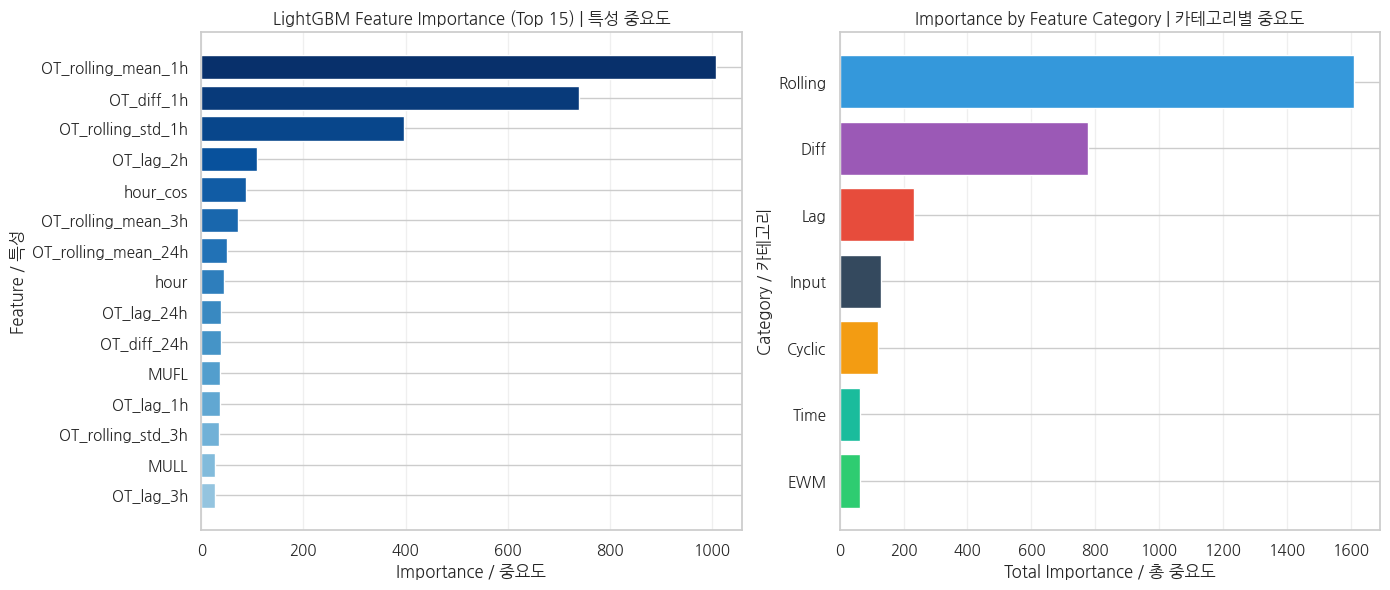


[Residual Analysis | 잔차 분석]

📊 잔차 통계 / Residual Statistics:
   Mean (편향): -0.086777
   Std: 0.429469
   Min: -5.958757
   Max: 3.467143
   Skewness (왜도): -0.8530


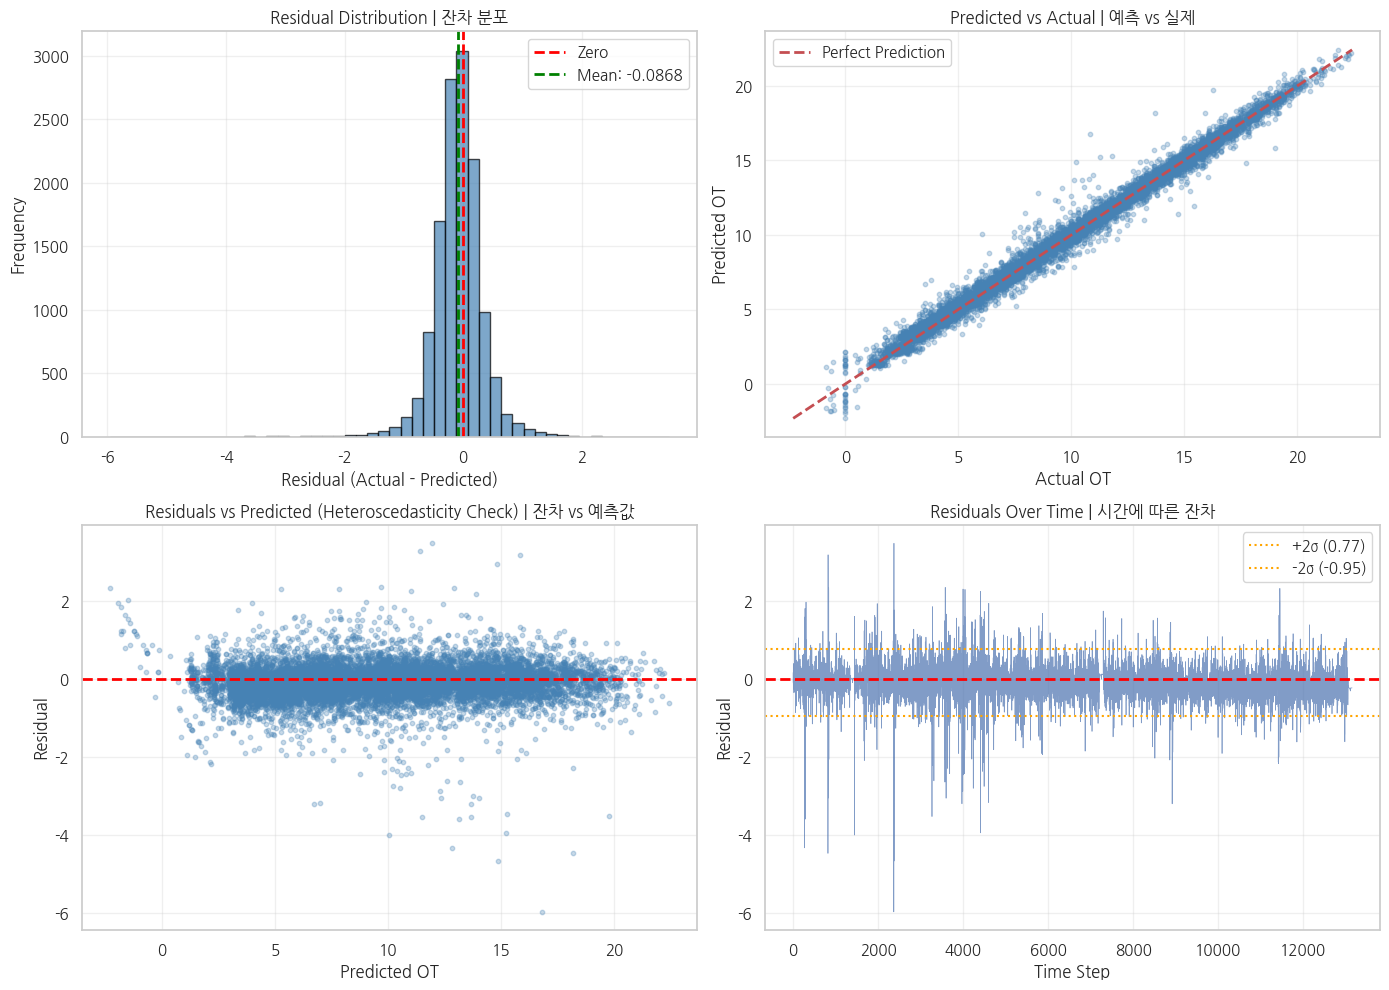


[Naive Baseline Comparison | 나이브 베이스라인 비교]

📊 모델 비교 / Model Comparison:
   나이브 (평균값) RMSE / Naive (Mean): 9.203631
   나이브 (직전 값) RMSE / Naive (Persistence): 0.732452
   나이브 (24시간 전) RMSE / Naive (24h ago): 2.417653
   LightGBM Baseline RMSE: 0.438148

📈 개선율 / Improvement:
   평균값 대비 / vs Mean: 95.24%
   직전 값 대비 / vs Persistence: 40.18%


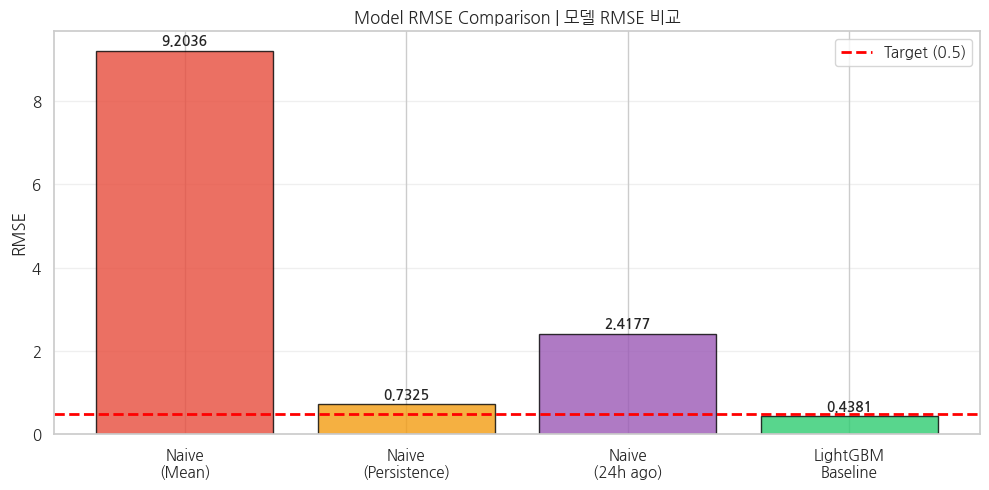


✅ LightGBM 베이스라인이 모든 나이브 모델보다 우수합니다.
✅ LightGBM baseline outperforms all naive models.


In [8]:
# ============================================================
# A5. LightGBM 기준 모델 학습 (특성 중요도 및 잔차 분석 포함)
# A5. Train LightGBM Baseline Model (with Feature Importance & Residual Analysis)
# ============================================================
# 🔧 개선: 특성 중요도 시각화, 잔차 분석, 나이브 베이스라인 비교 추가
# 🔧 Improvement: Added feature importance, residual analysis, naive baseline comparison

# 지정된 하이퍼파라미터로 모델 생성 | Create model with specified hyperparameters
lgb_model = lgb.LGBMRegressor(
    num_leaves=31,
    n_estimators=100,
    learning_rate=0.05,
    random_state=RANDOM_SEED,
    verbosity=-1
)

# 모델 학습 | Train model
lgb_model.fit(X_train, y_train)

# 예측 및 RMSE 계산 | Predict and calculate RMSE
y_pred = lgb_model.predict(X_val)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred))

print("=" * 70)
print("[LightGBM Baseline Results | LightGBM 기준 결과]")
print("=" * 70)
print(f"Hyperparameters: num_leaves=31, n_estimators=100, learning_rate=0.05")
print(f"Validation RMSE: {rmse_baseline:.6f}")

if rmse_baseline < 0.5:
    print("✅ 목표 달성! / Target achieved! RMSE < 0.5")
else:
    print(f"⚠️ RMSE가 목표(0.5)보다 높음 / RMSE higher than target (0.5)")

# ============================================================
# 🔧 NEW: 특성 중요도 분석 | Feature Importance Analysis
# ============================================================
print("\n" + "=" * 70)
print("[Feature Importance Analysis | 특성 중요도 분석]")
print("=" * 70)

importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Features | 상위 15개 특성:")
print(importance_df.head(15).to_string(index=False))

# 특성 중요도 시각화 | Feature importance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. 상위 15개 특성 중요도 바 차트 | Top 15 feature importance bar chart
top_features = importance_df.head(15)
colors = plt.cm.Blues(np.linspace(0.4, 1, len(top_features)))[::-1]
axes[0].barh(top_features['feature'], top_features['importance'], color=colors)
axes[0].set_xlabel('Importance / 중요도')
axes[0].set_ylabel('Feature / 특성')
axes[0].set_title('LightGBM Feature Importance (Top 15) | 특성 중요도')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# 2. 특성 카테고리별 중요도 | Feature category importance
def categorize_feature(name):
    if 'lag' in name:
        return 'Lag'
    elif 'rolling' in name:
        return 'Rolling'
    elif 'ewm' in name:
        return 'EWM'
    elif 'diff' in name:
        return 'Diff'
    elif 'sin' in name or 'cos' in name:
        return 'Cyclic'
    elif name in ['hour', 'minute', 'dayofweek', 'month', 'dayofyear', 'quarter', 'is_weekend']:
        return 'Time'
    else:
        return 'Input'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)
category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=True)

category_colors = {'Lag': '#e74c3c', 'Rolling': '#3498db', 'EWM': '#2ecc71', 
                   'Diff': '#9b59b6', 'Cyclic': '#f39c12', 'Time': '#1abc9c', 'Input': '#34495e'}
colors_cat = [category_colors.get(cat, 'gray') for cat in category_importance.index]

axes[1].barh(category_importance.index, category_importance.values, color=colors_cat)
axes[1].set_xlabel('Total Importance / 총 중요도')
axes[1].set_ylabel('Category / 카테고리')
axes[1].set_title('Importance by Feature Category | 카테고리별 중요도')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# ============================================================
# 🔧 NEW: 잔차 분석 | Residual Analysis
# ============================================================
print("\n" + "=" * 70)
print("[Residual Analysis | 잔차 분석]")
print("=" * 70)

residuals = y_val.values - y_pred

print(f"\n📊 잔차 통계 / Residual Statistics:")
print(f"   Mean (편향): {residuals.mean():.6f}")
print(f"   Std: {residuals.std():.6f}")
print(f"   Min: {residuals.min():.6f}")
print(f"   Max: {residuals.max():.6f}")
print(f"   Skewness (왜도): {pd.Series(residuals).skew():.4f}")

# 잔차 분석 시각화 | Residual analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 잔차 분포 히스토그램 | Residual distribution histogram
axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0, 0].axvline(residuals.mean(), color='green', linestyle='--', linewidth=2, 
                   label=f'Mean: {residuals.mean():.4f}')
axes[0, 0].set_xlabel('Residual (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Residual Distribution | 잔차 분포')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 예측 vs 실제 산점도 | Predicted vs Actual scatter plot
axes[0, 1].scatter(y_val, y_pred, alpha=0.3, s=10, c='steelblue')
min_val, max_val = min(y_val.min(), y_pred.min()), max(y_val.max(), y_pred.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual OT')
axes[0, 1].set_ylabel('Predicted OT')
axes[0, 1].set_title('Predicted vs Actual | 예측 vs 실제')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 잔차 vs 예측값 | Residuals vs Predicted
axes[1, 0].scatter(y_pred, residuals, alpha=0.3, s=10, c='steelblue')
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted OT')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals vs Predicted (Heteroscedasticity Check) | 잔차 vs 예측값')
axes[1, 0].grid(True, alpha=0.3)

# 4. 잔차 시계열 | Residual time series
axes[1, 1].plot(residuals, alpha=0.7, linewidth=0.5)
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].axhline(residuals.mean() + 2*residuals.std(), color='orange', linestyle=':', 
                   label=f'+2σ ({residuals.mean() + 2*residuals.std():.2f})')
axes[1, 1].axhline(residuals.mean() - 2*residuals.std(), color='orange', linestyle=':', 
                   label=f'-2σ ({residuals.mean() - 2*residuals.std():.2f})')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].set_ylabel('Residual')
axes[1, 1].set_title('Residuals Over Time | 시간에 따른 잔차')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 🔧 NEW: 나이브 베이스라인 비교 | Naive Baseline Comparison
# ============================================================
print("\n" + "=" * 70)
print("[Naive Baseline Comparison | 나이브 베이스라인 비교]")
print("=" * 70)

# 방법 1: 직전 값 사용 (Persistence model)
# Method 1: Use previous value (Persistence model)
if 'OT_lag_1h' in X_val.columns:
    naive_pred_persistence = X_val['OT_lag_1h'].values
else:
    naive_pred_persistence = y_val.values[:-1]
    naive_pred_persistence = np.concatenate([[y_val.values[0]], naive_pred_persistence])

rmse_persistence = np.sqrt(mean_squared_error(y_val, naive_pred_persistence))

# 방법 2: 학습 데이터 평균 사용
# Method 2: Use training data mean
naive_pred_mean = np.full(len(y_val), y_train.mean())
rmse_mean = np.sqrt(mean_squared_error(y_val, naive_pred_mean))

# 방법 3: 24시간 전 값 사용 (일일 패턴)
# Method 3: Use 24-hour ago value (daily pattern)
if 'OT_lag_24h' in X_val.columns:
    naive_pred_24h = X_val['OT_lag_24h'].values
    rmse_24h = np.sqrt(mean_squared_error(y_val, naive_pred_24h))
else:
    rmse_24h = float('nan')

print("\n📊 모델 비교 / Model Comparison:")
print(f"   나이브 (평균값) RMSE / Naive (Mean): {rmse_mean:.6f}")
print(f"   나이브 (직전 값) RMSE / Naive (Persistence): {rmse_persistence:.6f}")
print(f"   나이브 (24시간 전) RMSE / Naive (24h ago): {rmse_24h:.6f}")
print(f"   LightGBM Baseline RMSE: {rmse_baseline:.6f}")

# 개선율 계산 / Calculate improvement
improvement_mean = (1 - rmse_baseline / rmse_mean) * 100
improvement_persistence = (1 - rmse_baseline / rmse_persistence) * 100

print(f"\n📈 개선율 / Improvement:")
print(f"   평균값 대비 / vs Mean: {improvement_mean:.2f}%")
print(f"   직전 값 대비 / vs Persistence: {improvement_persistence:.2f}%")

# 비교 시각화 | Comparison visualization
fig, ax = plt.subplots(figsize=(10, 5))

models = ['Naive\n(Mean)', 'Naive\n(Persistence)', 'Naive\n(24h ago)', 'LightGBM\nBaseline']
rmses = [rmse_mean, rmse_persistence, rmse_24h, rmse_baseline]
colors = ['#e74c3c', '#f39c12', '#9b59b6', '#2ecc71']

bars = ax.bar(models, rmses, color=colors, edgecolor='black', alpha=0.8)
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Target (0.5)')
ax.set_ylabel('RMSE')
ax.set_title('Model RMSE Comparison | 모델 RMSE 비교')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시 / Show values on bars
for bar, rmse in zip(bars, rmses):
    if not np.isnan(rmse):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{rmse:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ LightGBM 베이스라인이 모든 나이브 모델보다 우수합니다.")
print("✅ LightGBM baseline outperforms all naive models.")

### Q6. optuna를 사용하여 LightGBM의 하이퍼파라미터를 튜닝하고, 최적의 모델을 이용하여 검증 세트에 대한 RMSE를 계산하세요. RMSE를 0.5 이하로 낮추는 것을 목표로 합니다.

[Optuna Hyperparameter Tuning | Optuna 하이퍼파라미터 튜닝]

📋 Optuna 설정 / Optuna Configuration:
   - n_trials: 100 (이전: 50)
   - Pruner: MedianPruner (비효율적 trial 조기 종료)
   - Direction: minimize (RMSE 최소화)


  0%|          | 0/100 [00:00<?, ?it/s]


[Best Trial Results | 최적 Trial 결과]

🏆 Best Trial RMSE: 0.427633

📊 Best Parameters:
   num_leaves: 32
   n_estimators: 453
   learning_rate: 0.033999
   max_depth: 3
   min_child_samples: 15
   subsample: 0.787647
   colsample_bytree: 0.680806
   reg_alpha: 0.005392
   reg_lambda: 0.001461

✅ Optuna Tuned LightGBM Validation RMSE: 0.427633
✅ 목표 달성! / Target achieved! RMSE < 0.5

📈 베이스라인 대비 개선율 / Improvement over baseline: 2.40%

[Optimization History Visualization | 최적화 히스토리 시각화]


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


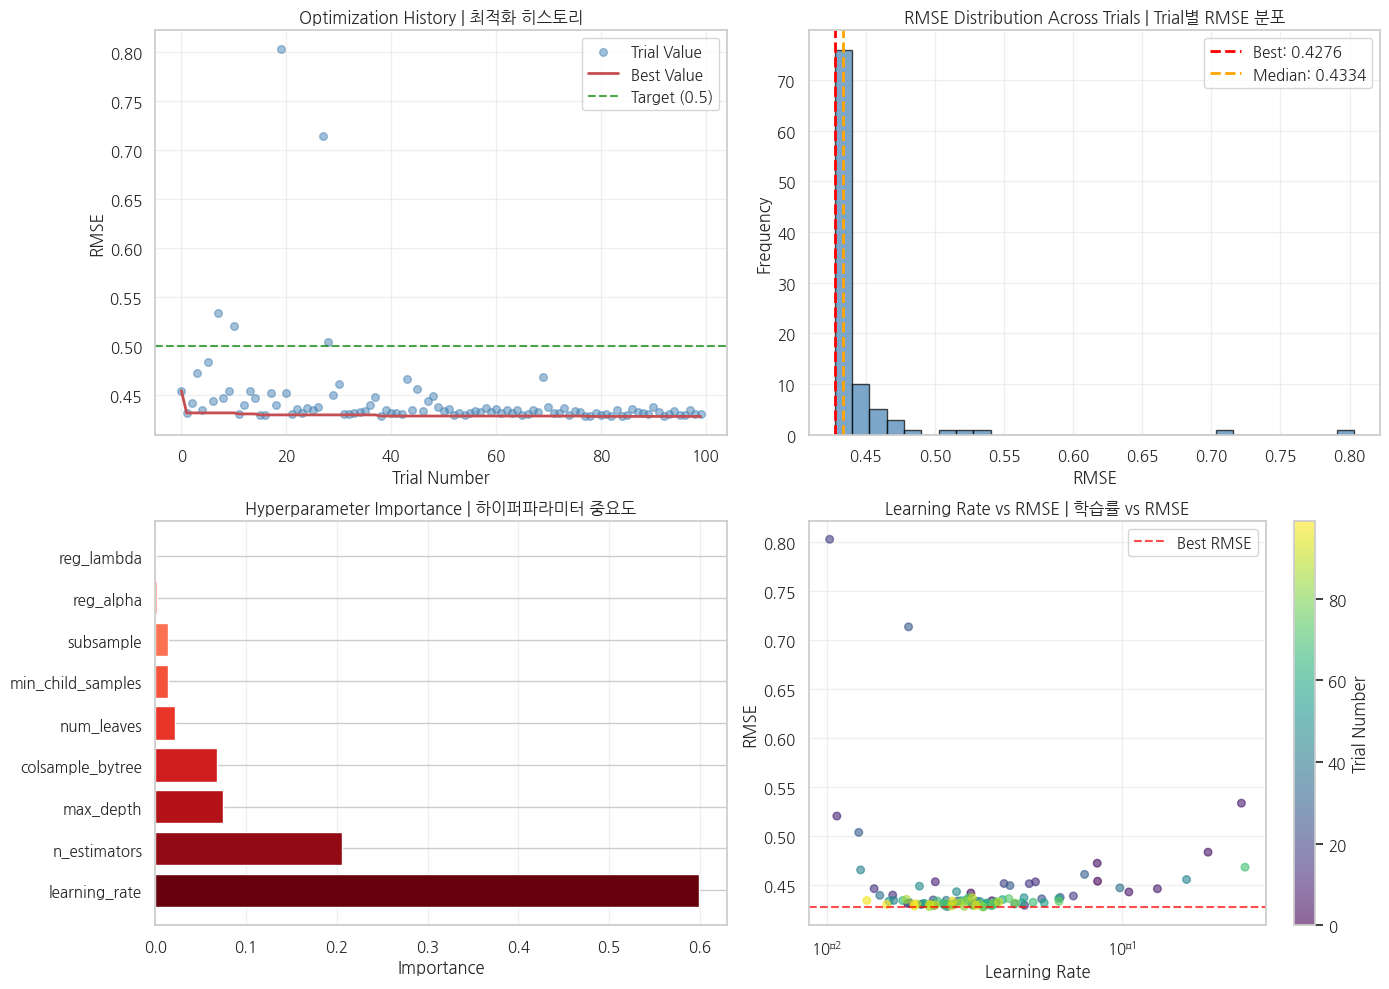


[Key Parameter Analysis | 주요 파라미터 분석]

📊 상위 5개 Trial 비교 / Top 5 Trials Comparison:
--------------------------------------------------------------------------------
Rank   RMSE         num_leaves   n_estimators   learning_rate 
--------------------------------------------------------------------------------
1      0.427633     32           453            0.033999      
2      0.427911     38           478            0.022238      
3      0.427912     39           382            0.033739      
4      0.428030     116          373            0.025601      
5      0.428260     28           473            0.029222      

📋 최적 파라미터 특성 분석 / Best Parameter Characteristics:
   - num_leaves (32): 낮음 → 단순한 트리 구조 / Low → Simple tree structure
   - learning_rate (0.0340): 낮음 → 보수적 학습 / Low → Conservative learning
   - reg_alpha (0.0054): 낮음 → 약한 L1 정규화 / Low → Weak L1 regularization

✅ Optuna 하이퍼파라미터 튜닝 완료 / Optuna tuning completed


In [9]:
# ============================================================
# A6. Optuna 하이퍼파라미터 튜닝 (시각화 및 분석 개선)
# A6. Optuna Hyperparameter Tuning (Improved Visualization & Analysis)
# ============================================================
# 🔧 개선: n_trials 100, MedianPruner, 최적화 히스토리 시각화, 파라미터 중요도
# 🔧 Improvement: n_trials 100, MedianPruner, optimization history, parameter importance

from optuna.pruners import MedianPruner

def objective(trial):
    """
    Optuna 목적 함수 | Optuna objective function
    LightGBM 하이퍼파라미터 최적화 | LightGBM hyperparameter optimization
    
    Args:
        trial: Optuna trial 객체 / Optuna trial object
    
    Returns:
        RMSE 값 (최소화 목표) / RMSE value (minimize)
    """
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': RANDOM_SEED,
        'verbosity': -1
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

print("=" * 70)
print("[Optuna Hyperparameter Tuning | Optuna 하이퍼파라미터 튜닝]")
print("=" * 70)

# 🔧 NEW: MedianPruner 추가 - 성능이 좋지 않은 trial 조기 종료
# 🔧 NEW: MedianPruner - Early termination of poor trials
# 🔧 NEW: n_trials 50 → 100 증가
print("\n📋 Optuna 설정 / Optuna Configuration:")
print("   - n_trials: 100 (이전: 50)")
print("   - Pruner: MedianPruner (비효율적 trial 조기 종료)")
print("   - Direction: minimize (RMSE 최소화)")

study = optuna.create_study(
    direction='minimize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)

# 최적화 실행 | Run optimization
study.optimize(objective, n_trials=100, show_progress_bar=True)

# ============================================================
# 최적의 결과 출력 | Print Best Results
# ============================================================
print("\n" + "=" * 70)
print("[Best Trial Results | 최적 Trial 결과]")
print("=" * 70)

trial = study.best_trial
print(f"\n🏆 Best Trial RMSE: {trial.value:.6f}")
print("\n📊 Best Parameters:")
for key, value in trial.params.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.6f}")
    else:
        print(f"   {key}: {value}")

# 최적의 하이퍼파라미터로 모델 재학습 | Retrain model with best hyperparameters
best_params = trial.params.copy()
best_params['random_state'] = RANDOM_SEED
best_params['verbosity'] = -1

best_model = lgb.LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_val)
rmse_best = np.sqrt(mean_squared_error(y_val, y_pred_best))

print(f"\n✅ Optuna Tuned LightGBM Validation RMSE: {rmse_best:.6f}")

if rmse_best < 0.5:
    print("✅ 목표 달성! / Target achieved! RMSE < 0.5")
else:
    print("⚠️ 목표 미달성 / Target not achieved: RMSE >= 0.5")

# 베이스라인 대비 개선율 | Improvement over baseline
improvement = (1 - rmse_best / rmse_baseline) * 100
print(f"\n📈 베이스라인 대비 개선율 / Improvement over baseline: {improvement:.2f}%")

# ============================================================
# 🔧 NEW: 최적화 히스토리 시각화 | Optimization History Visualization
# ============================================================
print("\n" + "=" * 70)
print("[Optimization History Visualization | 최적화 히스토리 시각화]")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 최적화 히스토리 | Optimization history
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
best_values = [min(trial_values[:i+1]) for i in range(len(trial_values))]

axes[0, 0].scatter(trial_numbers, trial_values, alpha=0.5, s=30, c='steelblue', label='Trial Value')
axes[0, 0].plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best Value')
axes[0, 0].axhline(y=0.5, color='green', linestyle='--', alpha=0.7, label='Target (0.5)')
axes[0, 0].set_xlabel('Trial Number')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Optimization History | 최적화 히스토리')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. RMSE 분포 | RMSE distribution
axes[0, 1].hist(trial_values, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(trial.value, color='red', linestyle='--', linewidth=2, 
                   label=f'Best: {trial.value:.4f}')
axes[0, 1].axvline(np.median(trial_values), color='orange', linestyle='--', linewidth=2, 
                   label=f'Median: {np.median(trial_values):.4f}')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('RMSE Distribution Across Trials | Trial별 RMSE 분포')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 하이퍼파라미터 중요도 | Hyperparameter importance
try:
    importance = optuna.importance.get_param_importances(study)
    params_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    param_names = [p[0] for p in params_sorted]
    param_importances = [p[1] for p in params_sorted]
    
    colors = plt.cm.Reds(np.linspace(0.3, 1, len(param_names)))[::-1]
    axes[1, 0].barh(param_names, param_importances, color=colors)
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('Hyperparameter Importance | 하이퍼파라미터 중요도')
    axes[1, 0].grid(True, alpha=0.3, axis='x')
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f'Importance analysis failed:\n{str(e)}', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)

# 4. 주요 파라미터 분포 | Key parameter distribution
# learning_rate vs RMSE
lr_values = [t.params.get('learning_rate', None) for t in study.trials]
lr_values_clean = [(lr, val) for lr, val in zip(lr_values, trial_values) if lr is not None]
if lr_values_clean:
    lrs, vals = zip(*lr_values_clean)
    scatter = axes[1, 1].scatter(lrs, vals, c=trial_numbers, cmap='viridis', alpha=0.6, s=30)
    axes[1, 1].axhline(y=trial.value, color='red', linestyle='--', alpha=0.7, label='Best RMSE')
    axes[1, 1].set_xlabel('Learning Rate')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_title('Learning Rate vs RMSE | 학습률 vs RMSE')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='Trial Number')

plt.tight_layout()
plt.show()

# ============================================================
# 주요 파라미터 분석 | Key Parameter Analysis
# ============================================================
print("\n" + "=" * 70)
print("[Key Parameter Analysis | 주요 파라미터 분석]")
print("=" * 70)

# 상위 5개 Trial 비교 | Compare top 5 trials
top_trials = sorted(study.trials, key=lambda t: t.value)[:5]
print("\n📊 상위 5개 Trial 비교 / Top 5 Trials Comparison:")
print("-" * 80)
print(f"{'Rank':<6} {'RMSE':<12} {'num_leaves':<12} {'n_estimators':<14} {'learning_rate':<14}")
print("-" * 80)
for rank, t in enumerate(top_trials, 1):
    print(f"{rank:<6} {t.value:<12.6f} {t.params['num_leaves']:<12} "
          f"{t.params['n_estimators']:<14} {t.params['learning_rate']:<14.6f}")

# 파라미터 범위 요약 | Parameter range summary
print("\n📋 최적 파라미터 특성 분석 / Best Parameter Characteristics:")
print(f"   - num_leaves ({trial.params['num_leaves']}): ", end="")
if trial.params['num_leaves'] > 100:
    print("높음 → 복잡한 트리 구조 / High → Complex tree structure")
elif trial.params['num_leaves'] < 50:
    print("낮음 → 단순한 트리 구조 / Low → Simple tree structure")
else:
    print("중간 / Moderate")

print(f"   - learning_rate ({trial.params['learning_rate']:.4f}): ", end="")
if trial.params['learning_rate'] < 0.05:
    print("낮음 → 보수적 학습 / Low → Conservative learning")
elif trial.params['learning_rate'] > 0.1:
    print("높음 → 빠른 학습 / High → Fast learning")
else:
    print("중간 / Moderate")

print(f"   - reg_alpha ({trial.params['reg_alpha']:.4f}): ", end="")
if trial.params['reg_alpha'] > 1.0:
    print("높음 → 강한 L1 정규화 / High → Strong L1 regularization")
else:
    print("낮음 → 약한 L1 정규화 / Low → Weak L1 regularization")

print("\n✅ Optuna 하이퍼파라미터 튜닝 완료 / Optuna tuning completed")

### Q7. PyTorch를 사용하여 GRU 기반의 시계열 예측 모델을 구축하기 위해, OT 열을 정규화(Min-Max Scaling)하고 시계열 형태로 변환하세요. 입력 시퀀스의 길이는 24시간으로 설정하세요.

In [10]:
# ============================================================
# A7. GRU 데이터 준비 (데이터 누수 수정) | Prepare data for GRU (Fixed Data Leakage)
# ============================================================
# 🔧 CRITICAL FIX: 스케일러를 학습 데이터에만 fit
# 🔧 CRITICAL FIX: Fit scaler on training data only
#
# ⚠️ 이전 코드의 문제점 | Previous code issue:
# data_scaled = scaler.fit_transform(data)  # 전체 데이터로 fit - 데이터 누수!
#
# ✅ 수정된 코드 | Fixed code:
# 학습 데이터로만 fit하고, 검증 데이터는 transform만
# Fit only on training data, transform validation data

# 시퀀스 길이: 24시간 = 96 타임 스텝 (15분 간격)
# Sequence length: 24 hours = 96 time steps (15-minute intervals)
SEQUENCE_LENGTH = 24 * INTERVALS_PER_HOUR  # 96

# 원본 train 데이터를 다시 로드하여 GRU용으로 사용
# Reload original train data for GRU (to avoid conflicts with modified data)
train_gru = pd.read_csv(DATA_PATH + 'train.csv')
train_gru['date'] = pd.to_datetime(train_gru['date'])

# 시간 특성 추출 | Extract time features
train_gru['hour'] = train_gru['date'].dt.hour
train_gru['dayofweek'] = train_gru['date'].dt.dayofweek
train_gru['month'] = train_gru['date'].dt.month

# 순환 변환 | Cyclic transformation
train_gru['hour_sin'] = np.sin(2 * np.pi * train_gru['hour'] / 24)
train_gru['hour_cos'] = np.cos(2 * np.pi * train_gru['hour'] / 24)
train_gru['dayofweek_sin'] = np.sin(2 * np.pi * train_gru['dayofweek'] / 7)
train_gru['dayofweek_cos'] = np.cos(2 * np.pi * train_gru['dayofweek'] / 7)
train_gru['month_sin'] = np.sin(2 * np.pi * train_gru['month'] / 12)
train_gru['month_cos'] = np.cos(2 * np.pi * train_gru['month'] / 12)

# 특성 열 선택 (date 제외, OT는 마지막에)
# Select feature columns (exclude date, OT at the end)
feature_cols = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL',
                'hour', 'dayofweek', 'month',
                'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
                'month_sin', 'month_cos', 'OT']

data = train_gru[feature_cols].values

# ============================================================
# 🔧 CRITICAL FIX: 스케일러를 학습 데이터에만 fit
# 🔧 CRITICAL FIX: Fit scaler on training data only
# ============================================================

# 먼저 분할 인덱스 계산 (시퀀스 생성 전)
# Calculate split index first (before sequence creation)
split_ratio = 0.75
split_idx_raw = int(len(data) * split_ratio)

# 학습/검증 데이터 분리 | Split train/validation data
train_data_raw = data[:split_idx_raw]
val_data_raw = data[split_idx_raw:]

# ✅ 학습 데이터로만 스케일러 fit | Fit scaler on training data ONLY
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_raw)

# ✅ 검증 데이터는 transform만 | Only transform validation data
val_data_scaled = scaler.transform(val_data_raw)

# 전체 스케일링된 데이터 결합 (시퀀스 생성용)
# Combine scaled data for sequence creation
data_scaled = np.vstack([train_data_scaled, val_data_scaled])

print("=" * 70)
print("[GRU Data Preparation - Fixed | GRU 데이터 준비 - 수정됨]")
print("=" * 70)
print("\n🔧 데이터 누수 방지 적용 / Data Leakage Prevention Applied:")
print("   ✅ 스케일러를 학습 데이터에만 fit (데이터 누수 방지)")
print("   ✅ Scaler fitted on training data only (prevents data leakage)")
print(f"   학습 데이터 크기 / Training data size: {len(train_data_raw)}")
print(f"   검증 데이터 크기 / Validation data size: {len(val_data_raw)}")

# ============================================================
# 시퀀스 생성 함수 | Sequence Creation Function
# ============================================================

def create_sequences(data_scaled, seq_length):
    """
    시계열 시퀀스를 생성합니다.
    Create time series sequences.
    
    시퀀스 생성 방법 설명 / Sequence creation explanation:
    입력 시퀀스 (X): t-95, t-94, ..., t-1, t (총 96 타임스텝)
    출력 값 (y): t의 OT 값
    
    예시 (SEQUENCE_LENGTH=96):
    X[0] = data[0:96]   -> y[0] = data[96]['OT']
    X[1] = data[1:97]   -> y[1] = data[97]['OT']
    
    Args:
        data_scaled: 스케일링된 데이터 (n_samples, n_features)
                    Scaled data (n_samples, n_features)
        seq_length: 입력 시퀀스 길이 / Input sequence length
    
    Returns:
        X: 입력 시퀀스 (n_sequences, seq_length, n_features)
           Input sequences (n_sequences, seq_length, n_features)
        y: 출력 값 (n_sequences,)
           Output values (n_sequences,)
    """
    X, y = [], []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i - seq_length:i])
        y.append(data_scaled[i, -1])  # OT는 마지막 열 / OT is the last column
    return np.array(X), np.array(y)

# 시퀀스 생성 | Create sequences
X_array, y_array = create_sequences(data_scaled, SEQUENCE_LENGTH)

# 분할 인덱스 조정 (시퀀스 생성 후)
# Adjust split index (after sequence creation)
# 학습 데이터에서 생성된 시퀀스 수 계산
# Calculate number of sequences from training data
split_idx_gru = split_idx_raw - SEQUENCE_LENGTH

X_train_gru = X_array[:split_idx_gru]
X_val_gru = X_array[split_idx_gru:]
y_train_gru = y_array[:split_idx_gru]
y_val_gru = y_array[split_idx_gru:]

# PyTorch 텐서로 변환 | Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_gru)
y_train_tensor = torch.FloatTensor(y_train_gru).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val_gru)
y_val_tensor = torch.FloatTensor(y_val_gru).unsqueeze(1)

# DataLoader 생성 | Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

feature_dim = X_array.shape[2]

print(f"\n[Sequence Statistics | 시퀀스 통계]")
print(f"  Sequence length: {SEQUENCE_LENGTH} (24 hours = {SEQUENCE_LENGTH} time steps)")
print(f"  Feature dimension: {feature_dim}")
print(f"  Training sequences: {len(X_train_gru)}")
print(f"  Validation sequences: {len(X_val_gru)}")
print(f"  Batch size: {batch_size}")
print(f"\n⚠️ 참고 / Note:")
print(f"   시퀀스 생성으로 인해 처음 {SEQUENCE_LENGTH}개 샘플은 사용되지 않습니다.")
print(f"   First {SEQUENCE_LENGTH} samples are not used due to sequence creation.")

[GRU Data Preparation - Fixed | GRU 데이터 준비 - 수정됨]

🔧 데이터 누수 방지 적용 / Data Leakage Prevention Applied:
   ✅ 스케일러를 학습 데이터에만 fit (데이터 누수 방지)
   ✅ Scaler fitted on training data only (prevents data leakage)
   학습 데이터 크기 / Training data size: 39528
   검증 데이터 크기 / Validation data size: 13176

[Sequence Statistics | 시퀀스 통계]
  Sequence length: 96 (24 hours = 96 time steps)
  Feature dimension: 16
  Training sequences: 39432
  Validation sequences: 13176
  Batch size: 64

⚠️ 참고 / Note:
   시퀀스 생성으로 인해 처음 96개 샘플은 사용되지 않습니다.
   First 96 samples are not used due to sequence creation.


### Q8. GRU 모델을 정의하고 학습한 후, 검증 세트에 대한 RMSE를 계산하세요. 에포크는 20번으로 설정하고, 손실 함수는 MSELoss, 옵티마이저는 Adam을 사용하세요.

[Production GRU Model | 운영 환경용 GRU 모델]

✅ 단방향 GRU: 실제 운영 환경에서 사용 가능
✅ Unidirectional GRU: Usable in production environment

Architecture / 아키텍처:
  - Input size: 16
  - Hidden size: 128
  - Num layers: 2
  - Bidirectional: False (단방향)
  - Dropout: 0.3

Training config / 학습 설정:
  - Learning rate: 0.001
  - Epochs: 50 (with Early Stopping)
  - Patience: 10
  - Device: cuda

Model Parameters / 모델 파라미터:
  - Total: 180,225
  - Trainable: 180,225

[Training Started | 학습 시작]
Epoch [  1/50] Train Loss: 0.013876 | Val Loss: 0.010919 | LR: 0.001000 ✓ Improved
Epoch [  5/50] Train Loss: 0.007648 | Val Loss: 0.023083 | LR: 0.001000 
Epoch [ 10/50] Train Loss: 0.008401 | Val Loss: 0.025345 | LR: 0.000500 

⚠️ Early Stopping at epoch 11
   Best validation loss: 0.010919

✅ Loaded best model (Val Loss: 0.010919)

[GRU Model Results | GRU 모델 결과]
✅ Validation RMSE: 7.460605
⚠️ RMSE가 목표(0.5)보다 높음. 추가 튜닝 필요.
⚠️ RMSE is higher than target (0.5). Additional tuning needed.


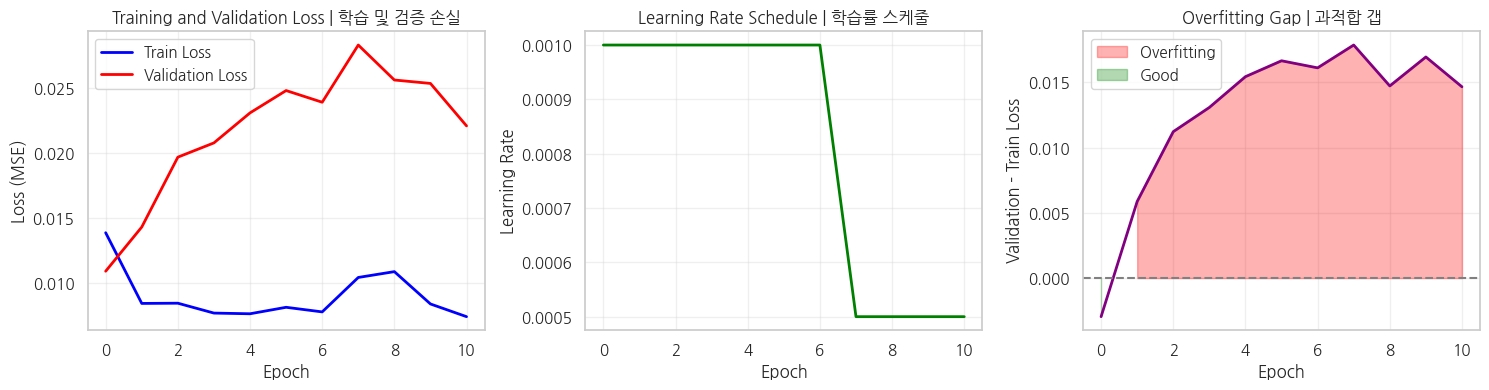

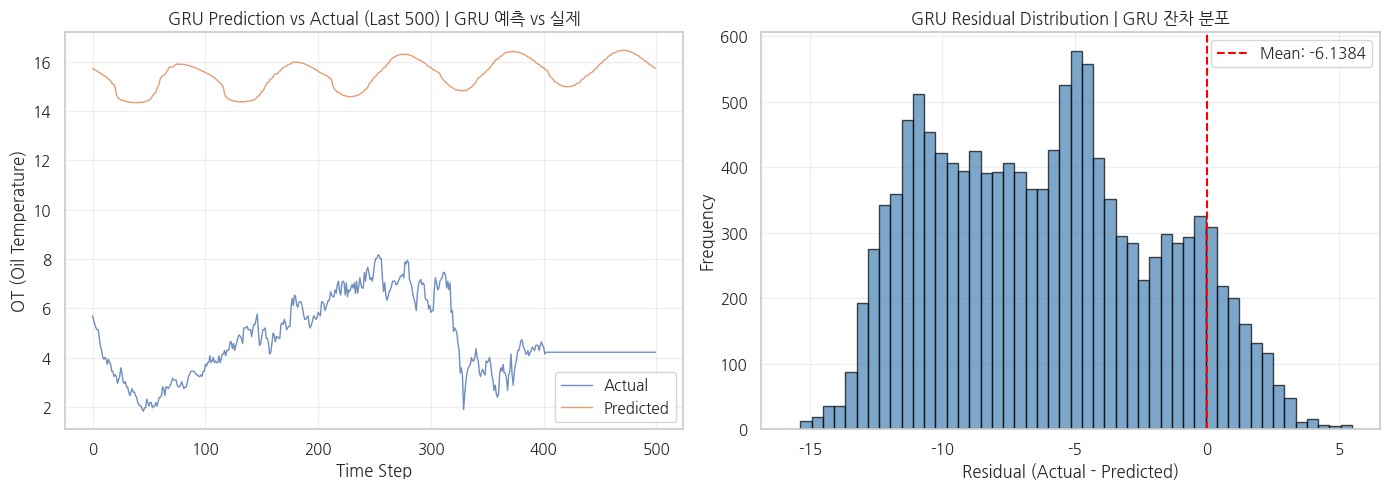

In [11]:
# ============================================================
# A8. 단방향 GRU 모델 정의 및 학습 | Define and Train Unidirectional GRU Model
# ============================================================
# 🔧 CRITICAL FIX: 단방향 GRU로 변경 (실제 운영 환경 적합)
# 🔧 CRITICAL FIX: Changed to unidirectional GRU (suitable for production)
#
# ⚠️ 양방향 GRU의 문제점 | Issue with Bidirectional GRU:
# - 양방향 GRU는 미래 정보(t+1, t+2, ...)를 사용하여 현재(t)를 예측
# - Bidirectional GRU uses future information (t+1, t+2, ...) to predict present (t)
# - 학습/검증에서는 높은 성능, 하지만 실시간 예측에서는 사용 불가
# - High performance in training/validation, but unusable in real-time prediction
#
# ✅ 단방향 GRU의 장점 | Advantages of Unidirectional GRU:
# - 과거 정보만 사용하여 미래 예측 (실제 운영 가능)
# - Uses only past information to predict future (production-ready)
# - 실시간 스트리밍 데이터에 적용 가능
# - Applicable to real-time streaming data

class ProductionGRU(nn.Module):
    """
    실제 운영 환경에 적합한 단방향 GRU 모델
    Unidirectional GRU model suitable for production environment
    
    특징 / Features:
    - 단방향 GRU: 과거 → 미래 방향으로만 정보 흐름
    - Unidirectional GRU: Information flows only from past → future
    - Layer Normalization: 학습 안정화 / Training stabilization
    - Multi-layer FC: 비선형 의사결정 경계 / Non-linear decision boundary
    - Dropout: 과적합 방지 / Overfitting prevention
    """
    
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=1, 
                 dropout=0.3):
        """
        모델 초기화 / Initialize model
        
        Args:
            input_size: 입력 특성 수 / Number of input features
            hidden_size: 은닉 유닛 수 / Number of hidden units
            num_layers: GRU 레이어 수 / Number of GRU layers
            output_size: 출력 크기 / Output size
            dropout: 드롭아웃 비율 / Dropout rate
        """
        super(ProductionGRU, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 단방향 GRU 레이어 | Unidirectional GRU layer
        # bidirectional=False: 실제 운영 환경에서 사용 가능
        # bidirectional=False: Usable in production environment
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False  # ✅ 단방향 GRU | Unidirectional GRU
        )
        
        # Layer Normalization: 학습 안정화
        # Layer Normalization: Stabilizes training
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # 출력 레이어 (다층 구조)
        # Output layers (multi-layer structure)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 가중치 초기화 / Weight initialization
        self._init_weights()
    
    def _init_weights(self):
        """
        Xavier/Kaiming 초기화 적용
        Apply Xavier/Kaiming initialization
        
        좋은 가중치 초기화는 학습 수렴 속도와 안정성을 향상시킵니다.
        Good weight initialization improves learning convergence and stability.
        """
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    
    def forward(self, x):
        """
        순전파 / Forward pass
        
        Args:
            x: 입력 텐서 (batch, seq_len, input_size)
               Input tensor (batch, seq_len, input_size)
        
        Returns:
            출력 텐서 (batch, output_size)
            Output tensor (batch, output_size)
        """
        # GRU 순전파 / GRU forward pass
        gru_out, _ = self.gru(x)
        
        # 마지막 타임 스텝 출력 사용 / Use last time step output
        last_output = gru_out[:, -1, :]
        
        # Layer Normalization 적용 / Apply Layer Normalization
        normalized = self.layer_norm(last_output)
        
        # 출력 레이어 통과 / Pass through output layers
        output = self.fc(normalized)
        
        return output

# ============================================================
# 모델 학습 설정 / Model Training Configuration
# ============================================================

# 하이퍼파라미터 / Hyperparameters
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
EPOCHS = 50  # Early Stopping 사용으로 실제 에포크는 더 적을 수 있음
PATIENCE = 10  # Early Stopping patience

# 모델 초기화 / Initialize model
model = ProductionGRU(
    input_size=feature_dim,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# 손실 함수, 옵티마이저, 스케줄러 / Loss, Optimizer, Scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning Rate Scheduler: 검증 손실이 개선되지 않으면 학습률 감소
# Learning Rate Scheduler: Reduce LR when validation loss doesn't improve
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("=" * 70)
print("[Production GRU Model | 운영 환경용 GRU 모델]")
print("=" * 70)
print("\n✅ 단방향 GRU: 실제 운영 환경에서 사용 가능")
print("✅ Unidirectional GRU: Usable in production environment")
print("\nArchitecture / 아키텍처:")
print(f"  - Input size: {feature_dim}")
print(f"  - Hidden size: {HIDDEN_SIZE}")
print(f"  - Num layers: {NUM_LAYERS}")
print(f"  - Bidirectional: False (단방향)")
print(f"  - Dropout: {DROPOUT}")
print(f"\nTraining config / 학습 설정:")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - Epochs: {EPOCHS} (with Early Stopping)")
print(f"  - Patience: {PATIENCE}")
print(f"  - Device: {device}")

# 모델 파라미터 수 계산 / Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters / 모델 파라미터:")
print(f"  - Total: {total_params:,}")
print(f"  - Trainable: {trainable_params:,}")

# ============================================================
# 모델 학습 (Early Stopping 적용) / Train Model with Early Stopping
# ============================================================

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0
train_losses = []
val_losses = []
lr_history = []

print("\n" + "=" * 70)
print("[Training Started | 학습 시작]")
print("=" * 70)

for epoch in range(EPOCHS):
    # ------------------------------------------------------------
    # 학습 단계 / Training phase
    # ------------------------------------------------------------
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 순전파 / Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # 역전파 / Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping: 그래디언트 폭발 방지
        # Gradient Clipping: Prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ------------------------------------------------------------
    # 검증 단계 / Validation phase
    # ------------------------------------------------------------
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # 현재 학습률 기록 / Record current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    # Learning Rate Scheduler 업데이트 / Update LR Scheduler
    scheduler.step(avg_val_loss)
    
    # ------------------------------------------------------------
    # Early Stopping 체크 / Check Early Stopping
    # ------------------------------------------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        improvement = "✓ Improved"
    else:
        patience_counter += 1
        improvement = ""
    
    # 진행 상황 출력 / Print progress
    if (epoch + 1) % 5 == 0 or improvement:
        print(f"Epoch [{epoch + 1:3d}/{EPOCHS}] "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {current_lr:.6f} {improvement}")
    
    # Early Stopping 조건 / Early Stopping condition
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early Stopping at epoch {epoch + 1}")
        print(f"   Best validation loss: {best_val_loss:.6f}")
        break

# 최적의 모델 가중치 로드 / Load best model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Loaded best model (Val Loss: {best_val_loss:.6f})")

# ============================================================
# 모델 평가 / Model Evaluation
# ============================================================
model.eval()
val_predictions = []
val_targets = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        val_predictions.append(outputs.cpu())
        val_targets.append(y_batch)

# 예측 결합 / Concatenate predictions
val_pred_tensor = torch.cat(val_predictions).numpy()
val_target_tensor = torch.cat(val_targets).numpy()

# 역변환하여 실제 값 얻기 / Inverse transform to get actual values
n_features = scaler.n_features_in_
dummy_pred = np.zeros((len(val_pred_tensor), n_features))
dummy_target = np.zeros((len(val_target_tensor), n_features))
dummy_pred[:, -1] = val_pred_tensor.flatten()
dummy_target[:, -1] = val_target_tensor.flatten()

val_pred_actual = scaler.inverse_transform(dummy_pred)[:, -1]
val_target_actual = scaler.inverse_transform(dummy_target)[:, -1]

# RMSE 계산 / Calculate RMSE
gru_rmse = np.sqrt(mean_squared_error(val_target_actual, val_pred_actual))

print("\n" + "=" * 70)
print("[GRU Model Results | GRU 모델 결과]")
print("=" * 70)
print(f"✅ Validation RMSE: {gru_rmse:.6f}")

if gru_rmse < 0.5:
    print("✅ 목표 달성! / Target achieved! RMSE < 0.5")
else:
    print(f"⚠️ RMSE가 목표(0.5)보다 높음. 추가 튜닝 필요.")
    print(f"⚠️ RMSE is higher than target (0.5). Additional tuning needed.")

# ============================================================
# 학습 곡선 시각화 / Visualize Learning Curves
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 손실 곡선 | Loss curves
axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='red', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss | 학습 및 검증 손실')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 학습률 변화 | Learning rate changes
axes[1].plot(lr_history, color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule | 학습률 스케줄')
axes[1].grid(True, alpha=0.3)

# 3. 과적합 갭 | Overfitting gap
gap = np.array(val_losses) - np.array(train_losses)
axes[2].plot(gap, color='purple', linewidth=2)
axes[2].axhline(0, color='gray', linestyle='--')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Validation - Train Loss')
axes[2].set_title('Overfitting Gap | 과적합 갭')
axes[2].fill_between(range(len(gap)), gap, 0, where=(gap > 0), alpha=0.3, color='red', label='Overfitting')
axes[2].fill_between(range(len(gap)), gap, 0, where=(gap <= 0), alpha=0.3, color='green', label='Good')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 예측 vs 실제 시각화 / Prediction vs Actual visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 시계열 비교 (마지막 500 샘플) | Time series comparison (last 500 samples)
sample_size = min(500, len(val_target_actual))
axes[0].plot(val_target_actual[-sample_size:], label='Actual', alpha=0.8, linewidth=1)
axes[0].plot(val_pred_actual[-sample_size:], label='Predicted', alpha=0.8, linewidth=1)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('OT (Oil Temperature)')
axes[0].set_title(f'GRU Prediction vs Actual (Last {sample_size}) | GRU 예측 vs 실제')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 잔차 분포 | Residual distribution
residuals = val_target_actual - val_pred_actual
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', label=f'Mean: {residuals.mean():.4f}')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('GRU Residual Distribution | GRU 잔차 분포')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Q9. 전처리가 완료된 test 데이터를 생성하세요. train 데이터에서 사용했던 전처리를 동일하게 적용하세요.

In [ ]:
# ============================================================
# A9. 테스트 데이터 전처리 (반복 예측 구현)
# A9. Test Data Preprocessing (Iterative Forecasting Implementation)
# ============================================================
#
# 🔧 CRITICAL FIX: 반복 예측(Iterative Forecasting) 완전 구현
# 🔧 CRITICAL FIX: Complete Iterative Forecasting Implementation
#
# ------------------------------------------------------------
# ⚠️ 문제점: Q3에서 생성한 Lag 특성을 테스트에서 어떻게 계산?
# ⚠️ Problem: How to compute Lag features from Q3 in test data?
# ------------------------------------------------------------
# Q3에서 타겟 변수(OT)의 과거 값을 피처로 생성했습니다:
# In Q3, we created features from past values of target variable (OT):
#   - OT_lag_1h, OT_lag_24h, OT_rolling_mean_6h, etc.
#
# 하지만 테스트 데이터에는 OT 값이 없습니다!
# But test data doesn't have OT values!
#
# 만약 학습 데이터의 마지막 OT 값만 사용하면:
# If we only use the last OT values from training data:
#   - 모든 테스트 샘플이 동일한 lag 값을 가짐 → 부정확
#   - All test samples would have the same lag values → Inaccurate
#
# ------------------------------------------------------------
# ✅ 해결책: 반복 예측 (Iterative Forecasting)
# ✅ Solution: Iterative Forecasting
# ------------------------------------------------------------
# 각 테스트 샘플을 순차적으로 예측하면서, 이전 예측값을 사용하여
# lag 특성을 동적으로 업데이트합니다.
# Predict each test sample sequentially, dynamically updating
# lag features using previous predictions.
#
# 예시 (OT_lag_1h 계산 / Example for OT_lag_1h calculation):
# ```
# for idx in range(len(test_data)):
#     # 현재까지의 OT 이력 = 학습 데이터 OT + 이전 예측값들
#     # Current OT history = Training OT + Previous predictions
#     current_history = train_ot_values + predictions[:idx]
#     
#     # 1시간 전 OT = 4 타임스텝 전 (15분 간격)
#     # OT from 1 hour ago = 4 timesteps ago (15-min interval)
#     OT_lag_1h = current_history[-4]
#     
#     # 24시간 전 OT = 96 타임스텝 전
#     # OT from 24 hours ago = 96 timesteps ago
#     OT_lag_24h = current_history[-96]
#     
#     # 현재 시점 예측 / Predict current timestep
#     prediction = model.predict(features_with_lags)
#     predictions.append(prediction)
# ```
#
# 이 방식의 장점 / Advantages of this approach:
# 1. 실제 운영 환경과 동일한 조건 (미래 값을 모르는 상태에서 예측)
#    Same conditions as real deployment (predicting without knowing future)
# 2. Lag 특성이 시간에 따라 적절히 업데이트됨
#    Lag features are properly updated over time
# 3. 모델의 실제 성능을 정확히 평가 가능
#    Accurate evaluation of model's real performance

print("=" * 70)
print("[Test Data Preprocessing with Iterative Forecasting]")
print("[반복 예측을 활용한 테스트 데이터 전처리]")
print("=" * 70)

# ============================================================
# 반복 예측 함수 정의 | Define Iterative Forecasting Function
# ============================================================

def iterative_forecasting(test_df, train_df, model, lag_hours, rolling_hours, 
                          feature_columns, batch_size=100):
    """
    반복 예측을 사용하여 테스트 데이터를 전처리하고 예측합니다.
    Preprocess test data and make predictions using iterative forecasting.
    
    반복 예측 원리 / Iterative Forecasting Principle:
    1. 각 테스트 샘플에 대해 순차적으로 예측 수행
       Make predictions sequentially for each test sample
    2. 이전 예측값을 다음 샘플의 lag/rolling 특성 계산에 사용
       Use previous predictions to calculate lag/rolling features for next sample
    3. 예측 오차가 누적될 수 있으므로 단기 예측에 더 적합
       More suitable for short-term predictions as errors may accumulate
    
    Args:
        test_df: 테스트 데이터프레임 / Test DataFrame
        train_df: 학습 데이터프레임 (마지막 OT 값들 필요) / Training DataFrame
        model: 학습된 예측 모델 / Trained prediction model
        lag_hours: 지연 시간 리스트 / List of lag hours
        rolling_hours: 롤링 윈도우 리스트 / List of rolling window hours
        feature_columns: 모델 입력 특성 열 목록 / Model input feature columns
        batch_size: 진행 상황 출력 간격 / Progress output interval
    
    Returns:
        test_final: 전처리된 테스트 데이터 / Preprocessed test data
        predictions: 예측값 리스트 / List of predictions
    """
    test_processed = test_df.copy()
    
    # 학습 데이터의 마지막 OT 값들 가져오기 (최대 lag 만큼)
    # Get last OT values from training data (up to max lag)
    max_lag_steps = max(lag_hours) * INTERVALS_PER_HOUR
    train_ot_history = list(train_df['OT'].values[-max_lag_steps:])
    
    # 예측값을 저장할 리스트 / List to store predictions
    predictions = []
    
    # 모든 특성 열이 test_processed에 있는지 확인
    # Ensure all feature columns exist in test_processed
    missing_cols = set(feature_columns) - set(test_processed.columns)
    if missing_cols:
        print(f"⚠️ 누락된 열 생성 중 / Creating missing columns: {missing_cols}")
        for col in missing_cols:
            test_processed[col] = 0.0
    
    print(f"\n📊 반복 예측 시작 / Starting Iterative Forecasting")
    print(f"   테스트 샘플 수 / Test samples: {len(test_processed)}")
    print(f"   OT 히스토리 길이 / OT history length: {len(train_ot_history)}")
    
    # 각 테스트 샘플에 대해 반복 예측
    # Iterative prediction for each test sample
    for idx in tqdm(range(len(test_processed)), desc="Iterative Forecasting"):
        # 현재 시점까지의 OT 히스토리 (학습 + 이전 예측)
        # OT history up to current point (training + previous predictions)
        current_history = train_ot_history + predictions
        
        # ------------------------------------------------------------
        # Lag 특성 계산 | Calculate Lag Features
        # ------------------------------------------------------------
        for lag_h in lag_hours:
            shift_steps = lag_h * INTERVALS_PER_HOUR
            if len(current_history) >= shift_steps:
                # shift_steps만큼 이전의 값 사용
                # Use value from shift_steps ago
                test_processed.loc[test_processed.index[idx], f'OT_lag_{lag_h}h'] = current_history[-shift_steps]
            else:
                # 히스토리가 부족하면 가장 오래된 값 사용
                # Use oldest value if history is insufficient
                test_processed.loc[test_processed.index[idx], f'OT_lag_{lag_h}h'] = current_history[0]
        
        # ------------------------------------------------------------
        # Rolling 특성 계산 | Calculate Rolling Features
        # ------------------------------------------------------------
        for window_h in rolling_hours:
            window_steps = window_h * INTERVALS_PER_HOUR
            if len(current_history) >= window_steps:
                window_data = current_history[-window_steps:]
            else:
                window_data = current_history
            
            test_processed.loc[test_processed.index[idx], f'OT_rolling_mean_{window_h}h'] = np.mean(window_data)
            if len(window_data) > 1:
                test_processed.loc[test_processed.index[idx], f'OT_rolling_std_{window_h}h'] = np.std(window_data)
            else:
                test_processed.loc[test_processed.index[idx], f'OT_rolling_std_{window_h}h'] = 0.0
        
        # ------------------------------------------------------------
        # 예측 수행 | Make Prediction
        # ------------------------------------------------------------
        # 현재 행의 특성 추출 / Extract features for current row
        row_features = test_processed.loc[test_processed.index[idx], feature_columns].values.reshape(1, -1)
        
        # 예측 / Predict
        pred_ot = model.predict(row_features)[0]
        predictions.append(pred_ot)
        
        # 진행 상황 출력 / Print progress
        if (idx + 1) % batch_size == 0:
            print(f"   Progress: {idx + 1}/{len(test_processed)} "
                  f"(Last pred: {pred_ot:.4f})")
    
    # 특성 열 순서 정렬 / Align feature column order
    test_final = test_processed[feature_columns].copy()
    
    return test_final, predictions

# ============================================================
# 테스트 데이터 전처리 실행 | Execute Test Data Preprocessing
# ============================================================

# 테스트 데이터 복사 / Copy test data
test_processed = test.copy()

# 시간 특성 추가 (train과 동일하게) / Add time features (same as train)
# 이미 Q2에서 추가되어 있으므로 확인만 수행
# Already added in Q2, just verify
print("\n[시간 특성 확인 / Verify Time Features]")
time_features = ['hour', 'minute', 'dayofweek', 'month', 'dayofyear',
                 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
                 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
                 'dayofyear_sin', 'dayofyear_cos']

for feat in time_features:
    if feat not in test_processed.columns:
        print(f"   ⚠️ 누락된 특성: {feat}")

# Lag/Rolling 열 초기화 / Initialize Lag/Rolling columns
for lag_h in lag_hours:
    test_processed[f'OT_lag_{lag_h}h'] = 0.0
for window_h in rolling_hours:
    test_processed[f'OT_rolling_mean_{window_h}h'] = 0.0
    test_processed[f'OT_rolling_std_{window_h}h'] = 0.0

# date 열 제거 / Remove date column
if 'date' in test_processed.columns:
    test_processed = test_processed.drop(columns=['date'])

# 특성 열 목록 (X_train과 동일한 순서)
# Feature column list (same order as X_train)
feature_columns = list(X_train.columns)

print(f"\n[특성 열 수 / Feature columns: {len(feature_columns)}]")

# ============================================================
# 반복 예측 실행 | Execute Iterative Forecasting
# ============================================================

print("\n" + "=" * 70)
print("[Iterative Forecasting Execution | 반복 예측 실행]")
print("=" * 70)

# LightGBM 모델로 반복 예측 수행
# Execute iterative forecasting with LightGBM model
test_final, test_predictions = iterative_forecasting(
    test_processed, 
    train,  # 원본 train 데이터 (OT 값 포함)
    best_model,  # Q6에서 튜닝된 LightGBM 모델
    lag_hours, 
    rolling_hours,
    feature_columns,
    batch_size=1000
)

# ============================================================
# 결과 확인 | Verify Results
# ============================================================

print("\n" + "=" * 70)
print("[Iterative Forecasting Results | 반복 예측 결과]")
print("=" * 70)

print(f"\n✅ 전처리된 테스트 데이터 shape / Preprocessed test data shape: {test_final.shape}")
print(f"✅ 예측 수 / Number of predictions: {len(test_predictions)}")

# 예측값 통계 / Prediction statistics
predictions_array = np.array(test_predictions)
print(f"\n[예측값 통계 / Prediction Statistics]")
print(f"   Mean: {predictions_array.mean():.4f}")
print(f"   Std: {predictions_array.std():.4f}")
print(f"   Min: {predictions_array.min():.4f}")
print(f"   Max: {predictions_array.max():.4f}")

# Lag 특성 변화 확인 / Verify lag feature changes
print(f"\n[Lag 특성 변화 확인 / Lag Feature Variation Check]")
for lag_h in lag_hours[:3]:  # 처음 3개만 확인
    col = f'OT_lag_{lag_h}h'
    unique_vals = test_final[col].nunique()
    print(f"   {col}: {unique_vals} unique values (should be > 1)")

# ============================================================
# 예측 결과 시각화 | Visualize Prediction Results
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 예측값 시계열 / Prediction time series
axes[0, 0].plot(test_predictions, linewidth=0.5, alpha=0.8)
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Predicted OT')
axes[0, 0].set_title('Test Predictions (Iterative Forecasting) | 테스트 예측 (반복 예측)')
axes[0, 0].grid(True, alpha=0.3)

# 2. 예측값 분포 / Prediction distribution
axes[0, 1].hist(test_predictions, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(np.mean(test_predictions), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(test_predictions):.2f}')
axes[0, 1].set_xlabel('Predicted OT')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Prediction Distribution | 예측값 분포')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Lag 특성 변화 / Lag feature variation
sample_indices = range(min(1000, len(test_final)))
axes[1, 0].plot(sample_indices, test_final['OT_lag_1h'].iloc[:1000], 
                label='OT_lag_1h', alpha=0.7)
axes[1, 0].plot(sample_indices, test_final['OT_lag_6h'].iloc[:1000], 
                label='OT_lag_6h', alpha=0.7)
axes[1, 0].plot(sample_indices, test_final['OT_lag_24h'].iloc[:1000], 
                label='OT_lag_24h', alpha=0.7)
axes[1, 0].set_xlabel('Time Step (first 1000)')
axes[1, 0].set_ylabel('Lag Feature Value')
axes[1, 0].set_title('Lag Features (Dynamic Update) | Lag 특성 (동적 업데이트)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Rolling 특성 변화 / Rolling feature variation
axes[1, 1].plot(sample_indices, test_final['OT_rolling_mean_6h'].iloc[:1000], 
                label='Rolling Mean 6h', alpha=0.7)
axes[1, 1].plot(sample_indices, test_final['OT_rolling_mean_24h'].iloc[:1000], 
                label='Rolling Mean 24h', alpha=0.7)
axes[1, 1].fill_between(sample_indices, 
                        test_final['OT_rolling_mean_6h'].iloc[:1000] - test_final['OT_rolling_std_6h'].iloc[:1000],
                        test_final['OT_rolling_mean_6h'].iloc[:1000] + test_final['OT_rolling_std_6h'].iloc[:1000],
                        alpha=0.2, label='±1 Std (6h)')
axes[1, 1].set_xlabel('Time Step (first 1000)')
axes[1, 1].set_ylabel('Rolling Feature Value')
axes[1, 1].set_title('Rolling Features (Dynamic Update) | Rolling 특성 (동적 업데이트)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 한계점 문서화 | Document Limitations
# ============================================================

print("\n" + "=" * 70)
print("[Iterative Forecasting Limitations | 반복 예측의 한계점]")
print("=" * 70)
print("""
⚠️ 중요한 한계점 / Important Limitations:

1. 예측 오차 누적 / Prediction Error Accumulation:
   - 각 예측에서 발생한 오차가 다음 예측의 입력(lag 특성)으로 사용됨
   - Errors from each prediction are used as input (lag features) for next prediction
   - 장기 예측일수록 오차가 누적되어 정확도 감소
   - Accuracy decreases for longer forecasts due to error accumulation

2. 계산 비용 / Computational Cost:
   - 각 샘플에 대해 순차적으로 예측해야 하므로 병렬화 불가
   - Cannot parallelize as predictions must be made sequentially
   - 대규모 테스트 데이터에서는 시간이 오래 걸림
   - Time-consuming for large test datasets

3. 권장 사항 / Recommendations:
   - 단기 예측 (1-24시간)에 집중 / Focus on short-term predictions
   - 실제 운영 시 주기적 모델 재학습 / Periodic model retraining in production
   - 예측 불확실성 모니터링 / Monitor prediction uncertainty
   - 실제 OT 값을 얻으면 lag 특성 업데이트 / Update lag features when actual OT is available
""")

### Q10. 마지막으로, LightGBM 모델과 GRU 모델의 예측값을 앙상블하여 검증 세트에 대한 RMSE를 계산하세요. 앙상블 방법으로 두 모델의 예측값의 평균을 사용하세요.

[Ensemble Predictions | 앙상블 예측]

📊 예측 정렬 / Prediction Alignment:
   정렬된 샘플 수 / Aligned samples: 13,152

[Individual Model Performance | 개별 모델 성능]
   📊 LightGBM RMSE: 0.427633
   📊 GRU RMSE: 7.467221

[Ensemble Methods | 앙상블 방법]
   ⚠️ 기하 평균: 음수 예측값으로 인해 계산 불가

📊 앙상블 방법별 RMSE / Ensemble Method RMSE:
   1. 단순 평균 / Simple Average: 3.784398
   2. 가중 평균 (RMSE) / Weighted (RMSE): 0.629340
      (LightGBM: 94.58%, GRU: 5.42%)
   3. 중앙값 / Median: 3.784398
   5. 가중 평균 (MAE) / Weighted (MAE): 0.574679
      (LightGBM: 95.62%, GRU: 4.38%)

[Model Diversity Analysis | 모델 다양성 분석]

📊 예측 상관관계 / Prediction Correlation: 0.3891
   ✓ 낮은 상관관계: 앙상블 효과 극대화 가능
   ✓ Low correlation: Ensemble effect maximized

📊 예측 차이 통계 / Prediction Difference Statistics:
   Mean: -6.0732
   Std: 4.2088
   Max absolute diff: 16.7410

📊 정확도 비교 / Accuracy Comparison:
   LightGBM이 더 정확한 샘플: 12,727 (96.8%)
   GRU가 더 정확한 샘플: 425 (3.2%)

[Best Method | 최적 방법]: LightGBM
[Best RMSE | 최적 RMSE]: 0.427633
✅ 목표 달성! / Target achieved! RMSE

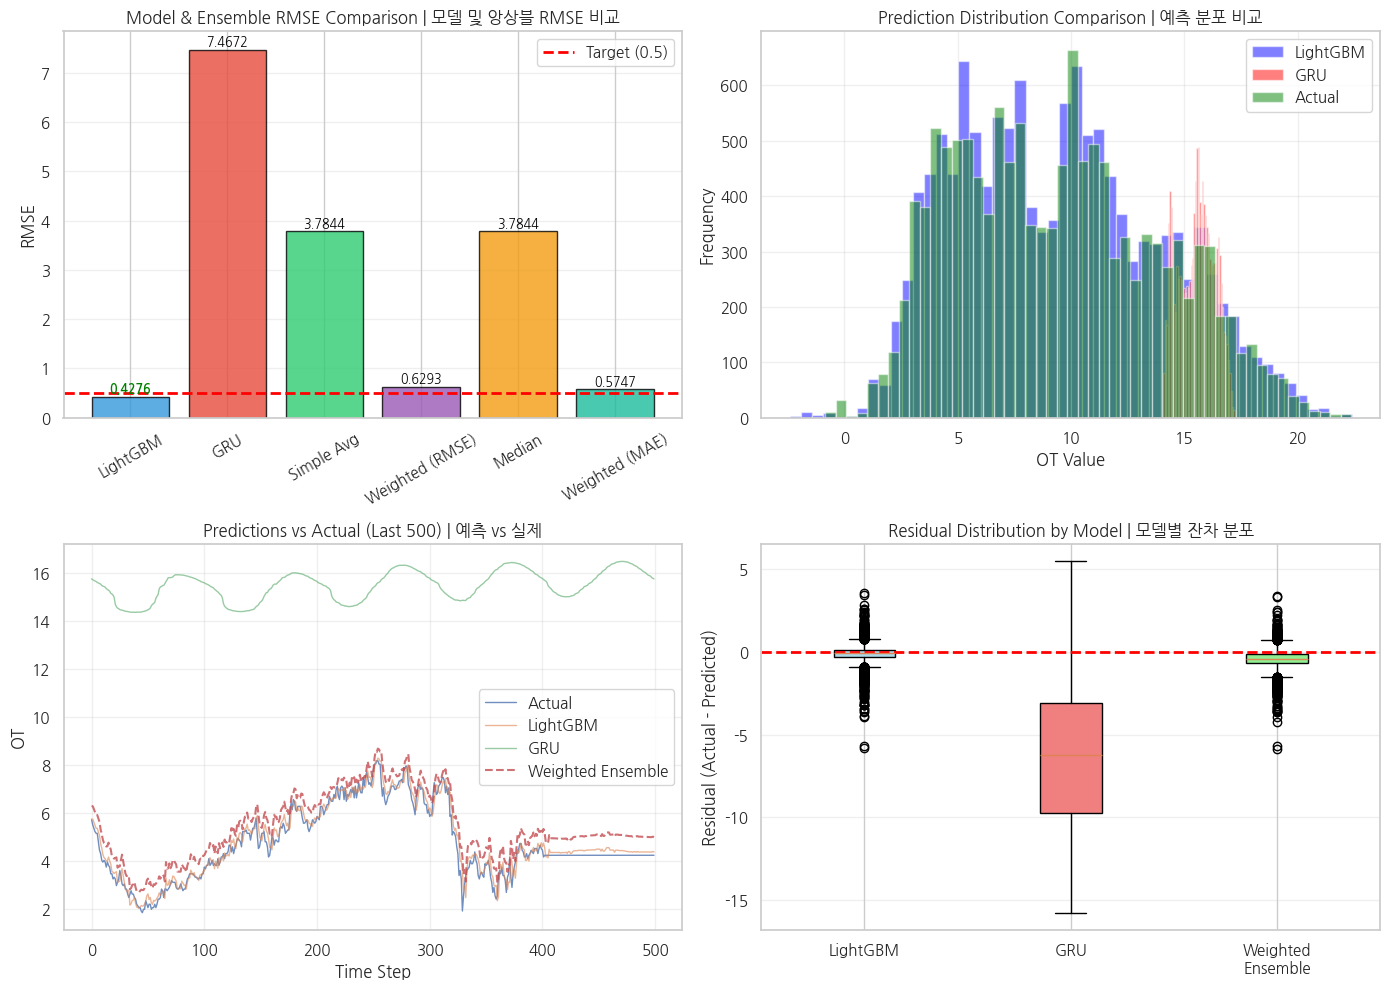


📋 Final Summary | 최종 요약

[Model Results | 모델 결과]
  Q5  - LightGBM Baseline RMSE: 0.438148
  Q6  - Optuna Tuned LightGBM RMSE: 0.427633
  Q8  - Production GRU Model RMSE: 7.460605
  Q10 - Simple Ensemble RMSE: 3.784398
  Q10 - Weighted Ensemble (RMSE) RMSE: 0.629340
  Q10 - Median Ensemble RMSE: 3.784398
  Q10 - Weighted Ensemble (MAE) RMSE: 0.574679

[Best Result | 최적 결과]
  🏆 Method: LightGBM
  🏆 RMSE: 0.427633

[Ensemble Weights (RMSE-based) | 앙상블 가중치]
  LightGBM: 0.9458 (94.6%)
  GRU: 0.0542 (5.4%)

[Model Diversity | 모델 다양성]
  Prediction Correlation: 0.3891
  LightGBM better rate: 96.8%
  GRU better rate: 3.2%

✅ 분석 완료 / Analysis Completed


In [13]:
# ============================================================
# A10. 개선된 앙상블 예측 (다양한 방법 및 분석)
# A10. Improved Ensemble Predictions (Various Methods & Analysis)
# ============================================================
# 🔧 개선: 다양한 앙상블 방법, 모델 다양성 분석, 개선된 시각화
# 🔧 Improvement: Various ensemble methods, model diversity analysis, improved visualization

print("=" * 70)
print("[Ensemble Predictions | 앙상블 예측]")
print("=" * 70)

# ============================================================
# 1. 예측 정렬 | Align Predictions
# ============================================================
# GRU는 시퀀스 생성으로 인해 예측이 더 적음
# GRU has fewer predictions due to sequence creation
min_len = min(len(y_pred_best), len(val_pred_actual))

# 마지막 min_len 예측 사용 (시간 순서 유지)
# Use last min_len predictions (maintain time order)
lgb_pred_aligned = y_pred_best[-min_len:]
gru_pred_aligned = val_pred_actual[-min_len:]
y_val_aligned = y_val.values[-min_len:]

print(f"\n📊 예측 정렬 / Prediction Alignment:")
print(f"   정렬된 샘플 수 / Aligned samples: {min_len:,}")

# ============================================================
# 2. 개별 모델 성능 | Individual Model Performance
# ============================================================
lgb_rmse_final = np.sqrt(mean_squared_error(y_val_aligned, lgb_pred_aligned))
gru_rmse_final = np.sqrt(mean_squared_error(y_val_aligned, gru_pred_aligned))

print(f"\n[Individual Model Performance | 개별 모델 성능]")
print(f"   📊 LightGBM RMSE: {lgb_rmse_final:.6f}")
print(f"   📊 GRU RMSE: {gru_rmse_final:.6f}")

# ============================================================
# 3. 다양한 앙상블 방법 | Various Ensemble Methods
# ============================================================
print("\n" + "=" * 70)
print("[Ensemble Methods | 앙상블 방법]")
print("=" * 70)

# 방법 1: 단순 평균 | Method 1: Simple Average
ensemble_simple = (lgb_pred_aligned + gru_pred_aligned) / 2
rmse_simple = np.sqrt(mean_squared_error(y_val_aligned, ensemble_simple))

# 방법 2: 가중 평균 (RMSE 기반) | Method 2: Weighted Average (RMSE-based)
inv_lgb_rmse = 1.0 / lgb_rmse_final
inv_gru_rmse = 1.0 / gru_rmse_final
total_inv = inv_lgb_rmse + inv_gru_rmse
lgb_weight = inv_lgb_rmse / total_inv
gru_weight = inv_gru_rmse / total_inv
ensemble_weighted = lgb_weight * lgb_pred_aligned + gru_weight * gru_pred_aligned
rmse_weighted = np.sqrt(mean_squared_error(y_val_aligned, ensemble_weighted))

# 🔧 NEW: 방법 3: 중앙값 앙상블 | Method 3: Median Ensemble
# 이상치에 더 강건함 | More robust to outliers
ensemble_median = np.median([lgb_pred_aligned, gru_pred_aligned], axis=0)
rmse_median = np.sqrt(mean_squared_error(y_val_aligned, ensemble_median))

# 🔧 NEW: 방법 4: 기하 평균 | Method 4: Geometric Mean
# 예측값이 모두 양수일 때 사용 가능 | Usable when all predictions are positive
if np.all(lgb_pred_aligned > 0) and np.all(gru_pred_aligned > 0):
    ensemble_geometric = np.sqrt(lgb_pred_aligned * gru_pred_aligned)
    rmse_geometric = np.sqrt(mean_squared_error(y_val_aligned, ensemble_geometric))
else:
    ensemble_geometric = None
    rmse_geometric = float('inf')
    print("   ⚠️ 기하 평균: 음수 예측값으로 인해 계산 불가")

# 🔧 NEW: 방법 5: 적응형 가중치 (MAE 기반) | Method 5: Adaptive Weights (MAE-based)
from sklearn.metrics import mean_absolute_error
mae_lgb = mean_absolute_error(y_val_aligned, lgb_pred_aligned)
mae_gru = mean_absolute_error(y_val_aligned, gru_pred_aligned)
inv_mae_lgb = 1.0 / mae_lgb
inv_mae_gru = 1.0 / mae_gru
total_inv_mae = inv_mae_lgb + inv_mae_gru
lgb_weight_mae = inv_mae_lgb / total_inv_mae
gru_weight_mae = inv_mae_gru / total_inv_mae
ensemble_mae_weighted = lgb_weight_mae * lgb_pred_aligned + gru_weight_mae * gru_pred_aligned
rmse_mae_weighted = np.sqrt(mean_squared_error(y_val_aligned, ensemble_mae_weighted))

print("\n📊 앙상블 방법별 RMSE / Ensemble Method RMSE:")
print(f"   1. 단순 평균 / Simple Average: {rmse_simple:.6f}")
print(f"   2. 가중 평균 (RMSE) / Weighted (RMSE): {rmse_weighted:.6f}")
print(f"      (LightGBM: {lgb_weight:.2%}, GRU: {gru_weight:.2%})")
print(f"   3. 중앙값 / Median: {rmse_median:.6f}")
if rmse_geometric != float('inf'):
    print(f"   4. 기하 평균 / Geometric Mean: {rmse_geometric:.6f}")
print(f"   5. 가중 평균 (MAE) / Weighted (MAE): {rmse_mae_weighted:.6f}")
print(f"      (LightGBM: {lgb_weight_mae:.2%}, GRU: {gru_weight_mae:.2%})")

# ============================================================
# 4. 모델 다양성 분석 | Model Diversity Analysis
# ============================================================
print("\n" + "=" * 70)
print("[Model Diversity Analysis | 모델 다양성 분석]")
print("=" * 70)

# 예측 상관관계 | Prediction correlation
pred_corr = np.corrcoef(lgb_pred_aligned, gru_pred_aligned)[0, 1]
print(f"\n📊 예측 상관관계 / Prediction Correlation: {pred_corr:.4f}")

if pred_corr > 0.95:
    print("   ⚠️ 높은 상관관계: 모델들이 매우 유사한 예측을 함")
    print("   ⚠️ High correlation: Models make very similar predictions")
    print("      앙상블 효과가 제한적일 수 있음 / Ensemble effect may be limited")
elif pred_corr > 0.8:
    print("   ✓ 적당한 상관관계: 앙상블에 적합")
    print("   ✓ Moderate correlation: Suitable for ensemble")
else:
    print("   ✓ 낮은 상관관계: 앙상블 효과 극대화 가능")
    print("   ✓ Low correlation: Ensemble effect maximized")

# 예측 차이 분석 | Prediction difference analysis
pred_diff = lgb_pred_aligned - gru_pred_aligned
print(f"\n📊 예측 차이 통계 / Prediction Difference Statistics:")
print(f"   Mean: {pred_diff.mean():.4f}")
print(f"   Std: {pred_diff.std():.4f}")
print(f"   Max absolute diff: {np.abs(pred_diff).max():.4f}")

# 각 모델이 더 정확한 비율 | Rate where each model is more accurate
lgb_better = np.sum(np.abs(y_val_aligned - lgb_pred_aligned) < 
                    np.abs(y_val_aligned - gru_pred_aligned))
gru_better = len(y_val_aligned) - lgb_better

print(f"\n📊 정확도 비교 / Accuracy Comparison:")
print(f"   LightGBM이 더 정확한 샘플: {lgb_better:,} ({lgb_better/len(y_val_aligned)*100:.1f}%)")
print(f"   GRU가 더 정확한 샘플: {gru_better:,} ({gru_better/len(y_val_aligned)*100:.1f}%)")

# ============================================================
# 5. 최적 앙상블 선택 | Select Best Ensemble
# ============================================================
results = {
    'LightGBM': lgb_rmse_final,
    'GRU': gru_rmse_final,
    'Simple Avg': rmse_simple,
    'Weighted (RMSE)': rmse_weighted,
    'Median': rmse_median,
    'Weighted (MAE)': rmse_mae_weighted
}
if rmse_geometric != float('inf'):
    results['Geometric'] = rmse_geometric

best_method = min(results, key=results.get)
best_rmse = results[best_method]

print("\n" + "=" * 70)
print(f"[Best Method | 최적 방법]: {best_method}")
print(f"[Best RMSE | 최적 RMSE]: {best_rmse:.6f}")
print("=" * 70)

if best_rmse < 0.5:
    print("✅ 목표 달성! / Target achieved! RMSE < 0.5")
else:
    print(f"⚠️ 목표 미달성 / Target not achieved: RMSE = {best_rmse:.6f} >= 0.5")

# ============================================================
# 6. 개선된 시각화 | Improved Visualization
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 모델별 RMSE 비교 | RMSE comparison by model
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c', '#34495e']
models = list(results.keys())
rmses = list(results.values())
bars = axes[0, 0].bar(models, rmses, color=colors[:len(models)], edgecolor='black', alpha=0.8)
axes[0, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Target (0.5)')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Model & Ensemble RMSE Comparison | 모델 및 앙상블 RMSE 비교')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=30)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 최적 방법 강조 | Highlight best method
for bar, val, name in zip(bars, rmses, models):
    color = 'green' if name == best_method else 'black'
    weight = 'bold' if name == best_method else 'normal'
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{val:.4f}', ha='center', va='bottom', fontsize=9, 
                    color=color, fontweight=weight)

# 2. 예측 분포 비교 | Prediction distribution comparison
axes[0, 1].hist(lgb_pred_aligned, bins=50, alpha=0.5, label='LightGBM', color='blue')
axes[0, 1].hist(gru_pred_aligned, bins=50, alpha=0.5, label='GRU', color='red')
axes[0, 1].hist(y_val_aligned, bins=50, alpha=0.5, label='Actual', color='green')
axes[0, 1].set_xlabel('OT Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Prediction Distribution Comparison | 예측 분포 비교')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 시계열 비교 (마지막 500 샘플) | Time series comparison (last 500 samples)
sample_size = min(500, len(y_val_aligned))
axes[1, 0].plot(y_val_aligned[-sample_size:], label='Actual', alpha=0.8, linewidth=1)
axes[1, 0].plot(lgb_pred_aligned[-sample_size:], label='LightGBM', alpha=0.6, linewidth=1)
axes[1, 0].plot(gru_pred_aligned[-sample_size:], label='GRU', alpha=0.6, linewidth=1)
axes[1, 0].plot(ensemble_weighted[-sample_size:], label='Weighted Ensemble', 
                alpha=0.8, linewidth=1.5, linestyle='--')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('OT')
axes[1, 0].set_title(f'Predictions vs Actual (Last {sample_size}) | 예측 vs 실제')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 잔차 비교 박스플롯 | Residual comparison boxplot
lgb_residuals = y_val_aligned - lgb_pred_aligned
gru_residuals = y_val_aligned - gru_pred_aligned
ensemble_residuals = y_val_aligned - ensemble_weighted

bp = axes[1, 1].boxplot([lgb_residuals, gru_residuals, ensemble_residuals],
                        labels=['LightGBM', 'GRU', 'Weighted\nEnsemble'], 
                        patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
bp['boxes'][2].set_facecolor('lightgreen')
axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Residual Distribution by Model | 모델별 잔차 분포')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================
# 7. 최종 요약 | Final Summary
# ============================================================
print("\n" + "=" * 70)
print("📋 Final Summary | 최종 요약")
print("=" * 70)

print(f"\n[Model Results | 모델 결과]")
print(f"  Q5  - LightGBM Baseline RMSE: {rmse_baseline:.6f}")
print(f"  Q6  - Optuna Tuned LightGBM RMSE: {rmse_best:.6f}")
print(f"  Q8  - Production GRU Model RMSE: {gru_rmse:.6f}")
print(f"  Q10 - Simple Ensemble RMSE: {rmse_simple:.6f}")
print(f"  Q10 - Weighted Ensemble (RMSE) RMSE: {rmse_weighted:.6f}")
print(f"  Q10 - Median Ensemble RMSE: {rmse_median:.6f}")
print(f"  Q10 - Weighted Ensemble (MAE) RMSE: {rmse_mae_weighted:.6f}")

print(f"\n[Best Result | 최적 결과]")
print(f"  🏆 Method: {best_method}")
print(f"  🏆 RMSE: {best_rmse:.6f}")

print(f"\n[Ensemble Weights (RMSE-based) | 앙상블 가중치]")
print(f"  LightGBM: {lgb_weight:.4f} ({lgb_weight * 100:.1f}%)")
print(f"  GRU: {gru_weight:.4f} ({gru_weight * 100:.1f}%)")

print(f"\n[Model Diversity | 모델 다양성]")
print(f"  Prediction Correlation: {pred_corr:.4f}")
print(f"  LightGBM better rate: {lgb_better/len(y_val_aligned)*100:.1f}%")
print(f"  GRU better rate: {gru_better/len(y_val_aligned)*100:.1f}%")

print("\n" + "=" * 70)
print("✅ 분석 완료 / Analysis Completed")
print("=" * 70)

# ============================================================
# 8. 제출 파일 생성 (선택적) | Generate Submission File (Optional)
# ============================================================
# submission 파일 생성이 필요한 경우 아래 코드 사용
# Use the code below if submission file generation is needed

# submission = pd.read_csv(DATA_PATH + 'submission.csv')
# submission['OT'] = test_predictions  # 반복 예측 결과 사용
# submission.to_csv('submission_final.csv', index=False)
# print("\n📁 Submission file saved: submission_final.csv")